In [163]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

# No absorption case
def universal_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        '''
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)
        
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        w_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        q3_s = w_3/(1+w_3)

        q1 = RH1 * q1_s
        q2 = RH2 * q2_s #specific humidity
        q3 = RH3 * q3_s #specific humidity
        '''
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        ''' Want to add the greenhouse effect.epsilon and tau.'''
        
        #q1 = RH_1 * q1_s #Need to change this relation to the exact definition
        #q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q3_s #specific humidity
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        fc = k3*np.log(Fc+1.0) # expression of cloud fraction versus convection
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))
        
        epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    #fc = 0    
    fc_2 = k3*np.log(Fc+1.0) # dayside cloud fraction versus convective flux
    if fc_2 >=1:             # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
        print('cloud fraction: ',fc_2)
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc_2 * (Flux1 + Flux2) - fc_2*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc_2, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [8]:
# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

universal_func(So=S, assumption='WTG',debug=True,\
    p_guess = (T1_init, T2_init, T3_init, T4_init, \
               Fa_init, Fc_init))

We have a solution:  (287.9710037145147, 264.84396822121334, 264.84396822121334, 253.73985883356656, 263.7398526263843, 315.5327848242644)


(287.9710037145147,
 264.84396822121334,
 264.84396822121334,
 253.73985883356656,
 263.7398526263843,
 315.5327848242644,
 0.46059414574098545,
 0.009780507716739072,
 0.0028210381501839353,
 0.001059757817088953,
 0.5091406726242967,
 0.9404559051022345,
 0.6534602738321669,
 227.119474751824,
 263.7398526248874,
 23.217571812231245,
 262.35046735858543,
 182.28989504989272,
 96.67104924878336,
 -58.44856441899272,
 {'nfev': 82,
  'fjac': array([[-1.92815418e-03,  1.91056286e-03, -1.64783669e-04,
           1.18891352e-04, -2.60759463e-13,  9.99996295e-01],
         [ 3.69712096e-01,  5.82589031e-01, -4.56910765e-02,
           4.45484819e-01, -5.68646091e-01, -4.60706187e-04],
         [-1.36263906e-01, -2.14725003e-01, -8.18006413e-01,
           4.95131575e-01,  1.45036378e-01, -4.61533346e-05],
         [-5.91215493e-02, -9.31619114e-02,  5.46414190e-01,
           7.30500710e-01,  3.94494285e-01,  6.71863923e-05],
         [ 2.08603750e-01, -7.71907882e-01,  1.40367527e-01,
    

In [10]:
# Example debug mode
S = 2000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

(T1, T2, T3, T4, Fa, Fc,  \
 fc_2, q1, q2, q3, alpha_p, \
 epsilon_2, epsilon_3, OLR_day, OLR_night, \
 Flux1, Flux2, Flux3 ,Flux4, FluxC, \
 info, ier, msg) = universal_func(So=S, assumption='WBG', debug=True, 
                                  p_guess = (T1_init, T2_init, T3_init, T4_init, \
                                             Fa_init, Fc_init))
print("\n")
print("T1 = {} K".format(round(T1,2)))
print("T2 = {} K".format(round(T2,2)))
print("T3 = {} K".format(round(T3,2)))
print("T4 = {} K".format(round(T4,2)))
print("F_a = {} W/m2".format(round(Fa,2)))
print("F_c = {} W/m2".format(round(Fc,2)))
print("dayside cloud fraction = {}".format(round(fc_2,2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1,4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2,4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3,6)))
print("planetary albedo = {}".format(round(alpha_p,3)))
print("dayside emissivity = {}".format(round(epsilon_2,3)))
print("nightside emissivity = {}".format(round(epsilon_3,3)))
print("dayside OLR = {} W/m2".format(round(OLR_day,1)))
print("nightside OLR = {} W/m2".format(round(OLR_night,1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1,1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2,1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC,1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3,1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4,1)))

We have a solution:  (287.40558287056353, 264.6046943446731, 264.85570159924515, 253.77897138977065, 263.8370322726157, 317.18048271984077)


T1 = 287.41 K
T2 = 264.6 K
T3 = 264.86 K
T4 = 253.78 K
F_a = 263.84 W/m2
F_c = 317.18 W/m2
dayside cloud fraction = 0.46
dayside surface specific humidity = 0.0094 kg/kg
dayside atmos specific humidity = 0.0028 kg/kg
nightside atmos specific humidity = 0.001061 kg/kg
planetary albedo = 0.51
dayside emissivity = 0.937
nightside emissivity = 0.654
dayside OLR = 226.6 W/m2
nightside OLR = 263.8 W/m2
dayside OLR = 226.6 W/m2
nightside OLR = 263.8 W/m2
dayside surface cooling = 24.3 W/m2
dayside atmospheric cooling = 260.5 W/m2
dayside cloud radiative effect = -58.1 W/m2
nightside surface cooling = 182.4 W/m2
nightside atmospheric cooling = 96.6 W/m2


In [164]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 3000 W/m2
nele = len(so)

# generate the empty output space
T1_arr, T2_arr, T3_arr, T4_arr, Fa_arr, Fc_arr, fc_arr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr, q2_arr, q3_arr, alpha_p_arr, epsilon_2_arr, epsilon_3_arr, OLR1_arr, OLR2_arr, Flux1_arr, Flux2_arr, Flux3_arr, Flux4_arr, FluxC_arr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (250,250,200,200,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_arr[idx], T2_arr[idx], T3_arr[idx], T4_arr[idx], Fa_arr[idx], Fc_arr[idx], fc_arr[idx], \
        q1_arr[idx],q2_arr[idx],q3_arr[idx],alpha_p_arr[idx],epsilon_2_arr[idx],epsilon_3_arr[idx], \
        OLR1_arr[idx], OLR2_arr[idx], Flux1_arr[idx], Flux2_arr[idx], Flux3_arr[idx], Flux4_arr[idx], FluxC_arr[idx], info,ier,msg = universal_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    initial_guess = (T1_arr[idx], T2_arr[idx], T3_arr[idx], T4_arr[idx], Fa_arr[idx], Fc_arr[idx])
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (264.33177600235126, 232.91833642746334, 232.91833642746334, 128.1461428777222, 24.692836466568263, 43.20720944538819)
1 850.0
We have a solution:  (266.71935068857175, 235.70392398476267, 235.70392398476267, 138.3943118184859, 33.26493958063863, 51.56849522728817)
2 900.0
We have a solution:  (268.71510582924486, 238.1119998671927, 238.1119998671927, 147.58944488401917, 42.57698079387835, 61.13930112727091)
3 950.0
We have a solution:  (270.41941944946416, 240.22876592323692, 240.22876592323692, 155.90276155171924, 52.425838397762696, 71.60154051029288)
4 1000.0
We have a solution:  (271.9020453423659, 242.11661228092927, 242.11661228092927, 163.4752741352804, 62.64683425701596, 82.71139174593158)
5 1050.0
We have a solution:  (273.21300741537624, 243.82213717452834, 243.82213717452834, 170.4241090659683, 73.1125680700716, 94.2822170922699)
6 1100.0
We have a solution:  (274.3890315309957, 245.38086681016398, 245.38086681016398, 176.84629433175232, 83.7270

### plotting

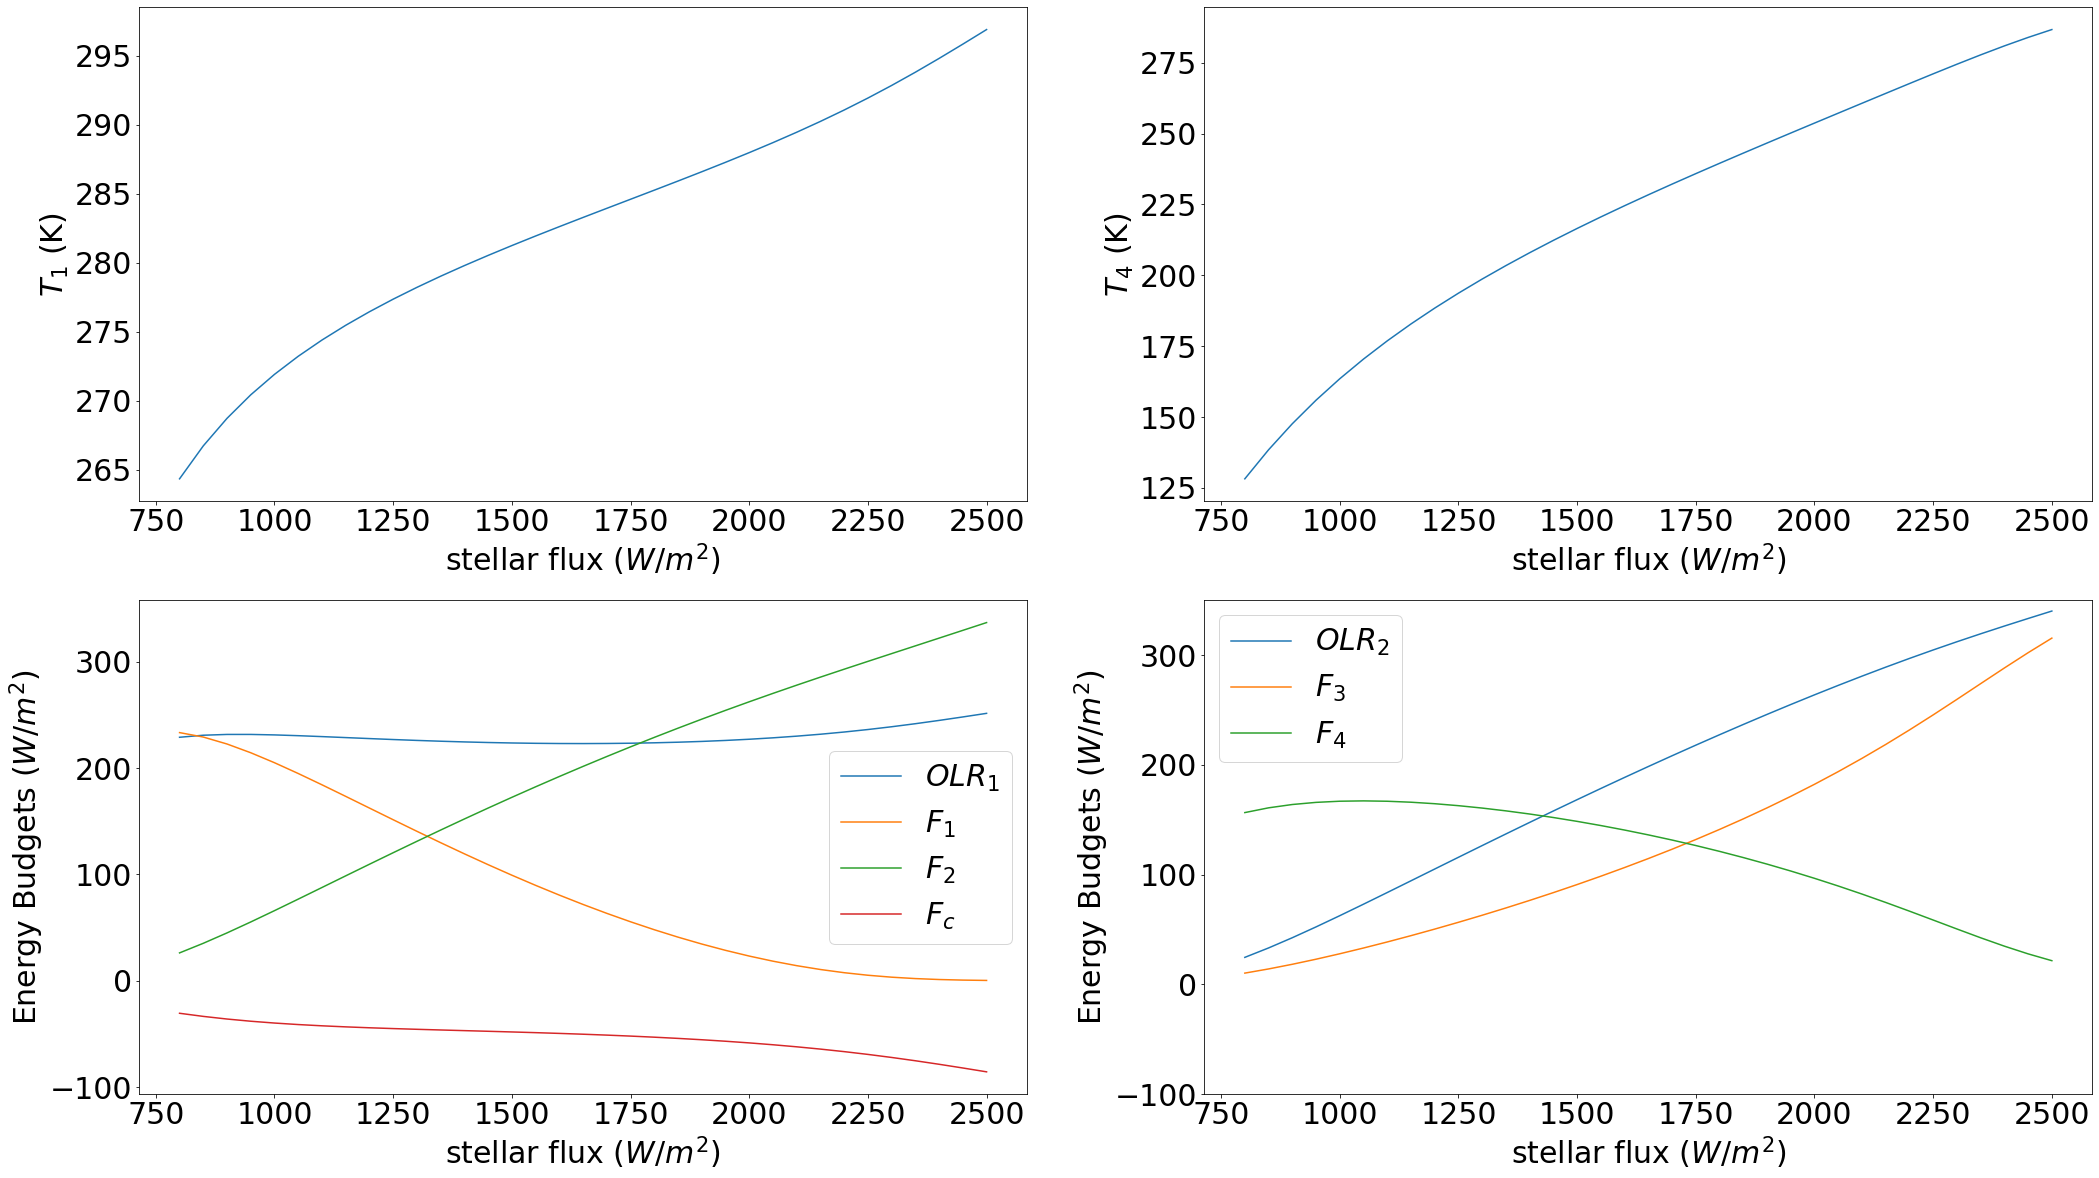

In [155]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Fig 5a, 5b from Yang and Abbot (2014)
    ax[0,0].plot(so, T1_arr)
    ax[0,0].set_ylabel(r'$T_1$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].plot(so, T4_arr)
    ax[0,1].set_ylabel(r'$T_4$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Fig 10a from Yang and Abbot (2014)
    ax[1,0].plot(so, OLR1_arr,label = r'$OLR_1$')
    ax[1,0].plot(so, Flux1_arr, label = r'$F_1$')
    ax[1,0].plot(so, Flux2_arr, label = r'$F_2$')
    ax[1,0].plot(so, FluxC_arr, label = r'$F_c$')
#     ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylim([-100, 350])
    ax[1,0].set_ylabel(r'Energy Budgets ($W/m^2$)')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Fig 10b from Yang and Abbot (2014)
    ax[1,1].plot(so, OLR2_arr, label = r'$OLR_2$')
    ax[1,1].plot(so, Flux3_arr, label = r'$F_3$')
    ax[1,1].plot(so, Flux4_arr, label = r'$F_4$')
#     ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylim([-100, 350])
    ax[1,1].set_ylabel(r'Energy Budgets ($W/m^2$)')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_8panels(so)

Text(0, 0.5, '$\\epsilon \\sigma T^4 (W/m^2)$')

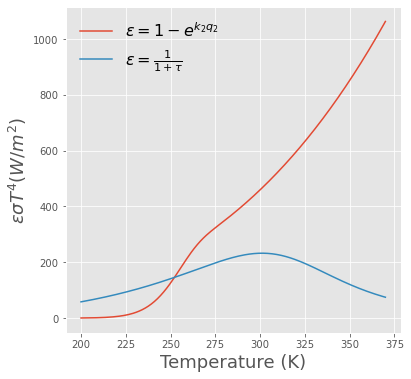

In [56]:
def tau(T,Tft):
    tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
    return tau


def epsilon_orig(T2):
    es0 = 611.2
    M = 0.018
    To = 273.15
    mm_dry = 0.028
    R_star = 8.3145
    mass_ratio = M/mm_dry
    L = 2.501e6 # J/kg #latent heat of vaporization
    Pc = 6e4
    RH2 = 0.8
    k2 = 1000
    
    es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
    ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
    w_2 = RH2 * ws_2
    q2 = w_2/(1+w_2)
    #q2_s = ws_2/(1+ws_2)
    epsilon_2 = 1 - np.exp(-k2*q2)
    return epsilon_2        


T = np.linspace(200,370,200)
epsilon_2_tau = 1/(1+tau(T,273))
epsilon_2 = epsilon_orig(T)

Lr_atm_gh = epsilon_2_tau*sigma*T**4
Lr_atm = epsilon_2*sigma*T**4

plt.rcParams['figure.constrained_layout.use']=False
fig = plt.figure(figsize =(6,6))
plt.style.use('ggplot')
#plt.style.use('default')

plt.plot(T, Lr_atm, label = r'$\epsilon = 1 - e^{k_2 q_2}$' )
plt.plot(T, Lr_atm_gh, label = r'$ \epsilon = \frac{1}{1+\tau}$' )
plt.legend(loc = 'best',fontsize=16, frameon = False)
plt.xlabel('Temperature (K)', fontsize = 18)
plt.ylabel(r'$\epsilon \sigma T^4 (W/m^2)$', fontsize = 18)


In [294]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

# With temperature-varying absorption
def solar_abs_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))

        def epsilon(q):
            k2 = 5000
            if q < 0:
                q = 0
            epsilon = 1 - np.exp(-k2*q)
            return epsilon        
        epsilon_2 = epsilon(q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = epsilon(q3)
        
#         epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 1e3      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [295]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_brr, T2_brr, T3_brr, T4_brr, Fa_brr, Fc_brr, fc_brr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_brr, q2_brr, q3_brr, alpha_p_brr, epsilon_2_brr, epsilon_3_brr, OLR1_brr, OLR2_brr, Flux1_brr, Flux2_brr, Flux3_brr, Flux4_brr, FluxC_brr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx], fc_brr[idx], \
        q1_brr[idx],q2_brr[idx],q3_brr[idx],alpha_p_brr[idx],epsilon_2_brr[idx],epsilon_3_brr[idx], \
        OLR1_brr[idx], OLR2_brr[idx], Flux1_brr[idx], Flux2_brr[idx], Flux3_brr[idx], Flux4_brr[idx], FluxC_brr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx], fc_brr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_brr[idx], q2_brr[idx], q3_brr[idx], alpha_p_brr[idx], epsilon_2_brr[idx], epsilon_3_brr[idx], OLR1_brr[idx], OLR2_brr[idx], Flux1_brr[idx], Flux2_brr[idx], Flux3_brr[idx], Flux4_brr[idx], FluxC_brr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
#         T1_brr[idx]= math.nan
#         T2_brr[idx]= math.nan
#         T3_brr[idx]= math.nan
#         T4_brr[idx]= math.nan
    else:
        initial_guess = (T1_brr[idx], T2_brr[idx], T3_brr[idx], T4_brr[idx], Fa_brr[idx], Fc_brr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (266.0135716184921, 234.8699728251243, 234.8699728251243, 192.03067249694766, 107.82195504150073, 4.899023259326845)
1 850.0
We have a solution:  (266.6254111614473, 235.59240297815612, 235.59240297815612, 195.1925945615622, 113.79562085673898, 8.984010533742735)
2 900.0
We have a solution:  (267.4376033078848, 236.5619706298313, 236.5619706298313, 199.40714454263846, 121.95961040493668, 13.674825253981142)
3 950.0
We have a solution:  (268.3693139083955, 237.68938303051186, 237.68938303051186, 204.25457333396278, 131.59498698296534, 18.6010578269177)
4 1000.0
We have a solution:  (269.3718140187825, 238.92094180961317, 238.92094180961317, 209.46753401339407, 142.1859180583926, 23.492482912326004)
5 1050.0
We have a solution:  (270.42284336468856, 240.23307562512318, 240.23307562512318, 214.90551966783886, 153.39789362735988, 28.140127692408083)
6 1100.0
We have a solution:  (271.51833120232874, 241.6238502152553, 241.6238502152553, 220.51284683714795, 165.

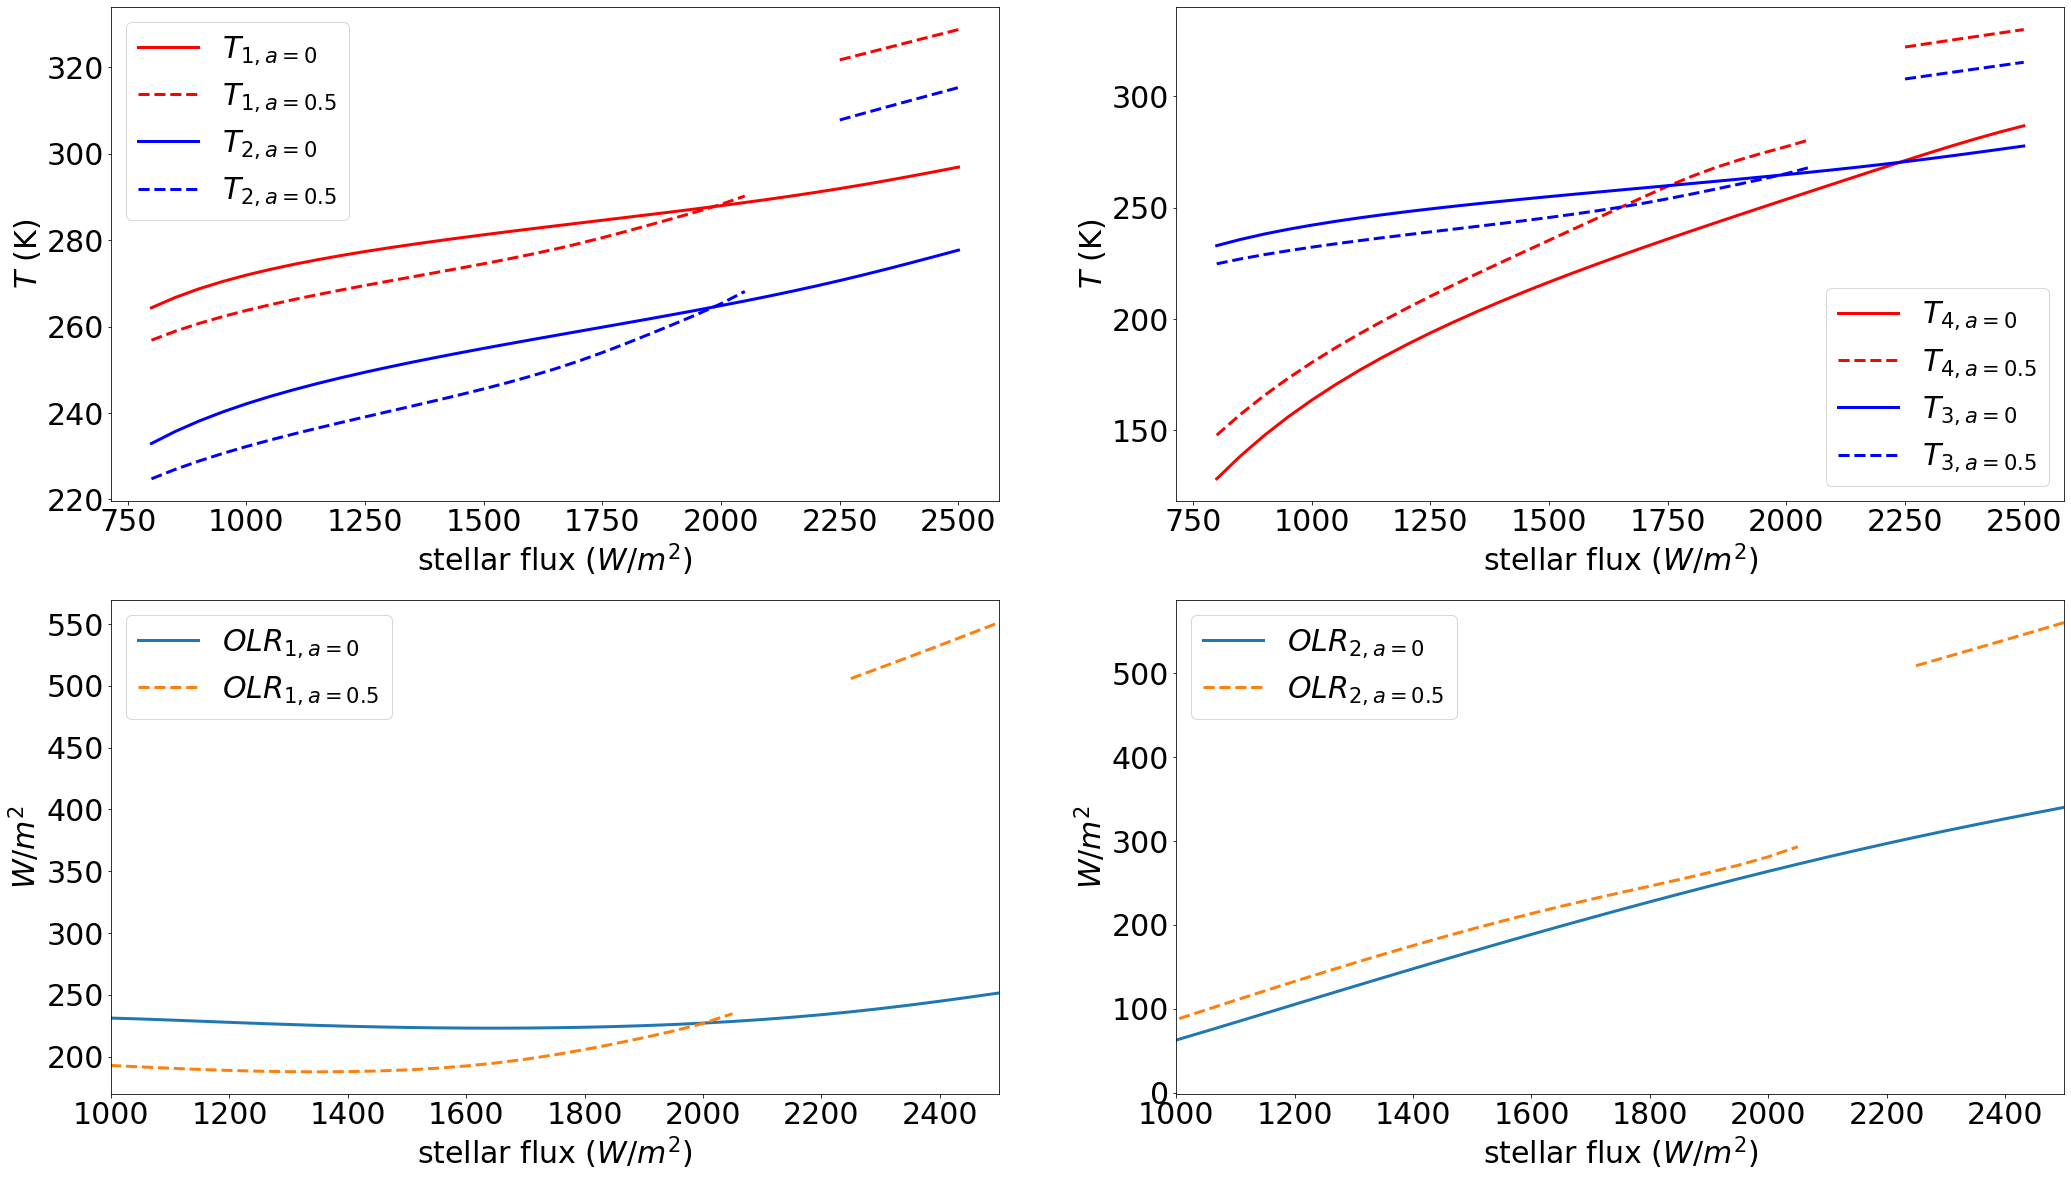

In [244]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_arr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0}$')
    ax[0,0].plot(so, T1_brr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.5}$')
    ax[0,0].plot(so, T2_arr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0}$')
    ax[0,0].plot(so, T2_brr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.5}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
    ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.5}$')
    ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
    ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.5}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].legend()
    
    # Dayside energy budgets
    ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
    ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.5}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Nightside energy budgets
    ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
    ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.5}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig

plot_abs(so)

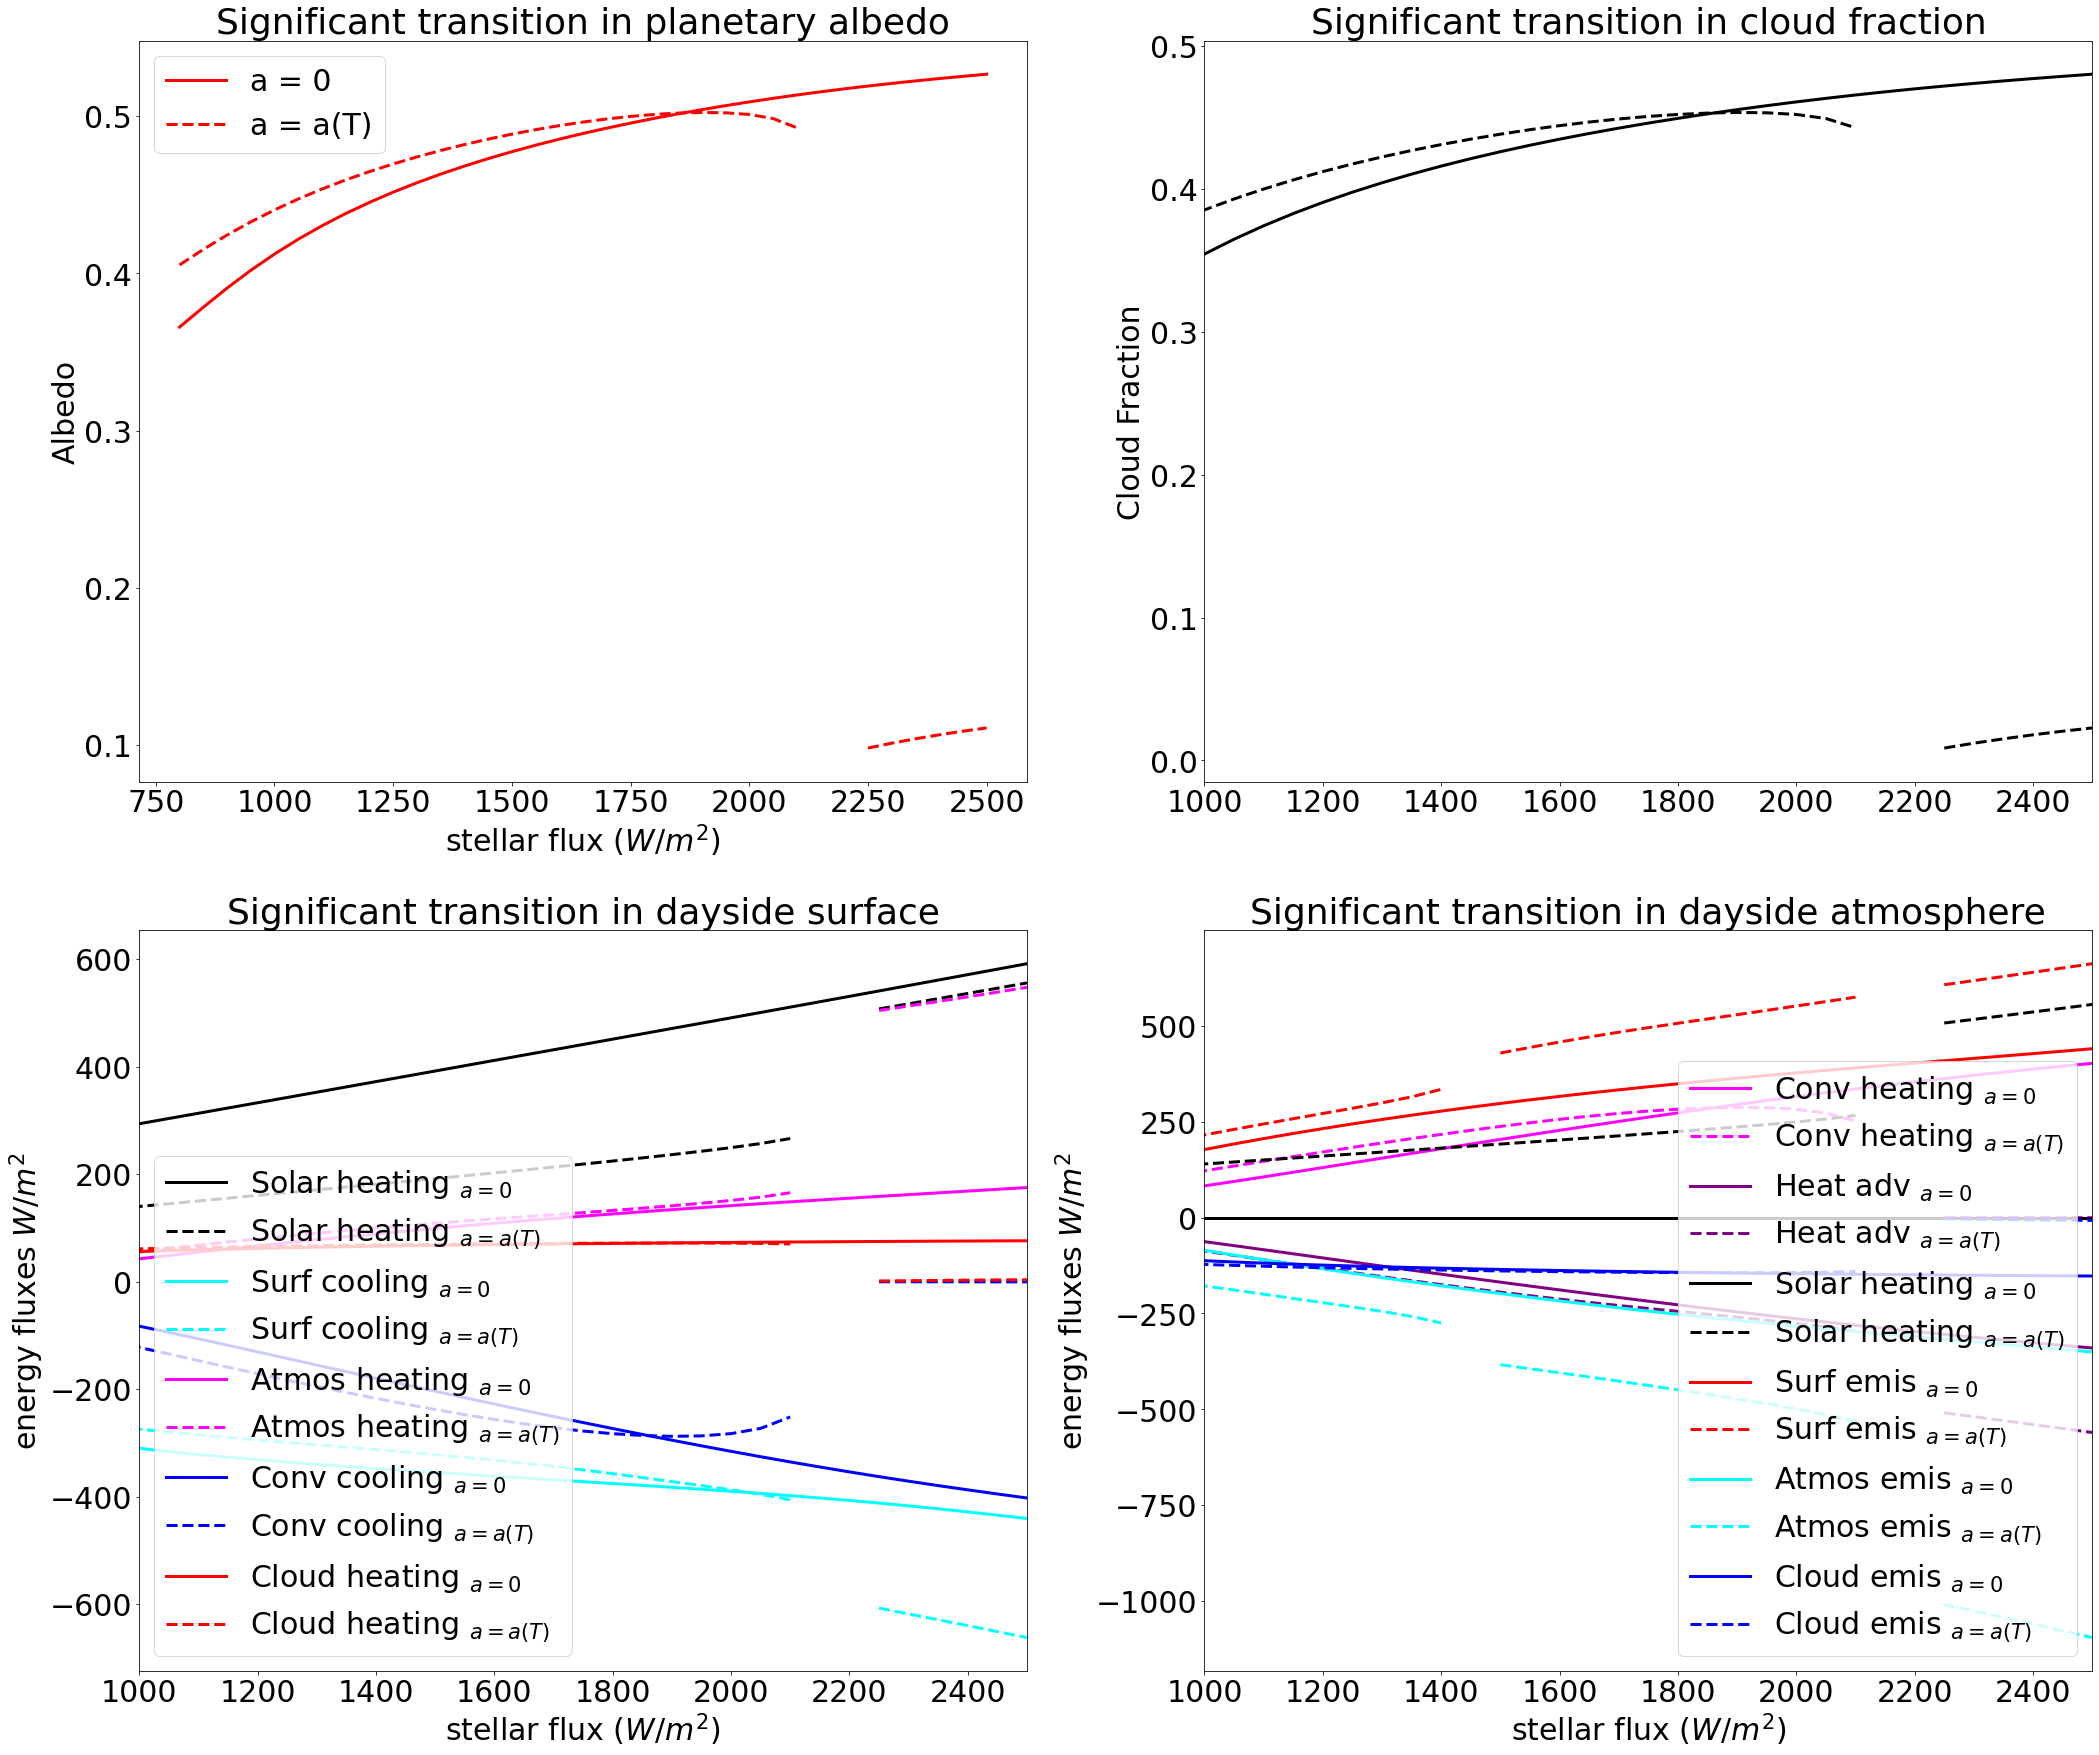

In [324]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.5
    
    fig, ax = plt.subplots(2, 2, figsize=(35,30)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, alpha_p_arr, '-', color = 'red',linewidth=3, label = "a = 0")
    ax[0,0].plot(so, alpha_p_hrr, '--', color = 'red', linewidth=3, label = "a = a(T)")
    ax[0,0].set_ylabel("Albedo")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title("Significant transition in planetary albedo")
    ax[0,0].legend()
    
    # Dayside emmisivity
    ax[0,1].plot(so, (fc_arr),'-', color = 'black',linewidth=3, label = "a = 0")
    ax[0,1].plot(so, (fc_hrr),'--', color = 'black',linewidth=3, label = "a = a(T)")
    ax[0,1].set_xlim([1000, 2500])
    ax[0,1].set_ylabel("Cloud Fraction")
    ax[0,1].set_title("Significant transition in cloud fraction")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Dayside energy budgets
    ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_hrr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a = a(T)}$')
    ax[1,0].plot(so, -sigma*T1_arr**4,'-', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0}$')
    ax[1,0].plot(so, -sigma*T1_hrr**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a = a(T)}$')
    ax[1,0].plot(so, (1-fc_arr)*Flux2_arr,'-', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0}$')
    ax[1,0].plot(so, (1-fc_hrr)*Flux2_hrr,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a = a(T)}$')
    ax[1,0].plot(so, -Fc_arr,'-', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0}$')
    ax[1,0].plot(so, -Fc_hrr,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{a = a(T)}$')
    ax[1,0].plot(so, fc_arr*sigma*Tc**4,'-', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0}$')
    ax[1,0].plot(so, fc_hrr*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{a = a(T)}$')  
    
#     ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr) + fc_arr*sigma*Tc**4 - sigma*T1_arr**4 + (1-fc_arr)*Flux2_arr - Fc_arr,'-', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0}$')
#     ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr) + fc_brr*sigma*Tc**4 - sigma*T1_brr**4 + (1-fc_brr)*Flux2_brr - Fc_brr,'--', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0.5}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'energy fluxes $W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend(loc = 3)
    ax[1,0].set_title("Significant transition in dayside surface")
    
    # Nightside energy budgets
    ax[1,1].plot(so, Fc_arr,'-', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0}$')
    ax[1,1].plot(so, Fc_hrr,'--', color = 'magenta',linewidth=3, label = r'Conv heating $_{a = a(T)}$')
    ax[1,1].plot(so, -Fa_arr,'-', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0}$')
    ax[1,1].plot(so, -Fa_hrr,'--', color = 'purple',linewidth=3, label = r'Heat adv $_{a = a(T)}$')
    ax[1,1].plot(so, so/2*(1-1)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,1].plot(so, so/2*a*(1-alpha_p_hrr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a = a(T)}$')
    ax[1,1].plot(so, ((1-fc_arr)*epsilon_2_arr+fc_arr)*sigma*T1_arr**4,'-', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0}$')
    ax[1,1].plot(so, ((1-fc_hrr)*epsilon_2_hrr+fc_hrr)*sigma*T1_brr**4,'--', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a = a(T)}$')
    ax[1,1].plot(so, -2*(1-fc_arr)*epsilon_2_arr*sigma*T2_arr**4,'-', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0}$')
    ax[1,1].plot(so, -2*(1-fc_hrr)*epsilon_2_brr*sigma*T2_brr**4,'--', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a = a(T)}$')
    ax[1,1].plot(so, -2*fc_arr*sigma*Tc**4,'-', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0}$')
    ax[1,1].plot(so, -2*fc_hrr*sigma*Tc**4,'--', color = 'blue',linewidth=3, label = r'Cloud emis $_{a = a(T)}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'energy fluxes $W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    ax[1,1].set_title("Significant transition in dayside atmosphere")
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)

In [72]:
print("Check variables")
print("T1 = {} K".format(round(T1_brr[0],2)))
print("T2 = {} K".format(round(T2_brr[0],2)))
print("T3 = {} K".format(round(T3_brr[0],2)))
print("T4 = {} K".format(round(T4_brr[0],2)))
print("F_a = {} W/m2".format(round(Fa_brr[0],2)))
print("F_c = {} W/m2".format(round(Fc_brr[0],2)))
print("dayside cloud fraction = {}".format(round(fc_brr[0],2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1_brr[0],4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2_brr[0],4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3_brr[0],6)))
print("planetary albedo = {}".format(round(alpha_p_brr[0],3)))
print("dayside emissivity = {}".format(round(epsilon_2_brr[0],3)))
print("nightside emissivity = {}".format(round(epsilon_3_brr[0],3)))
print("dayside OLR = {} W/m2".format(round(OLR1_brr[0],1)))
print("nightside OLR = {} W/m2".format(round(OLR2_brr[0],1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1_brr[0],1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2_brr[0],1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC_brr[0],1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3_brr[0],1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4_brr[0],1)))

Check variables
T1 = 279.43 K
T2 = 252.35 K
T3 = 252.35 K
T4 = 205.9 K
F_a = 142.75 W/m2
F_c = 3.43 W/m2
dayside cloud fraction = 0.12
dayside surface specific humidity = 0.0055 kg/kg
dayside atmos specific humidity = 0.001 kg/kg
nightside atmos specific humidity = 0.000384 kg/kg
planetary albedo = 0.198
dayside emissivity = 0.641
nightside emissivity = 0.319
dayside OLR = 258.1 W/m2
nightside OLR = 142.8 W/m2
dayside surface cooling = 124.2 W/m2
dayside atmospheric cooling = 147.4 W/m2
dayside cloud radiative effect = -52.0 W/m2
nightside surface cooling = 73.4 W/m2
nightside atmospheric cooling = 156.6 W/m2


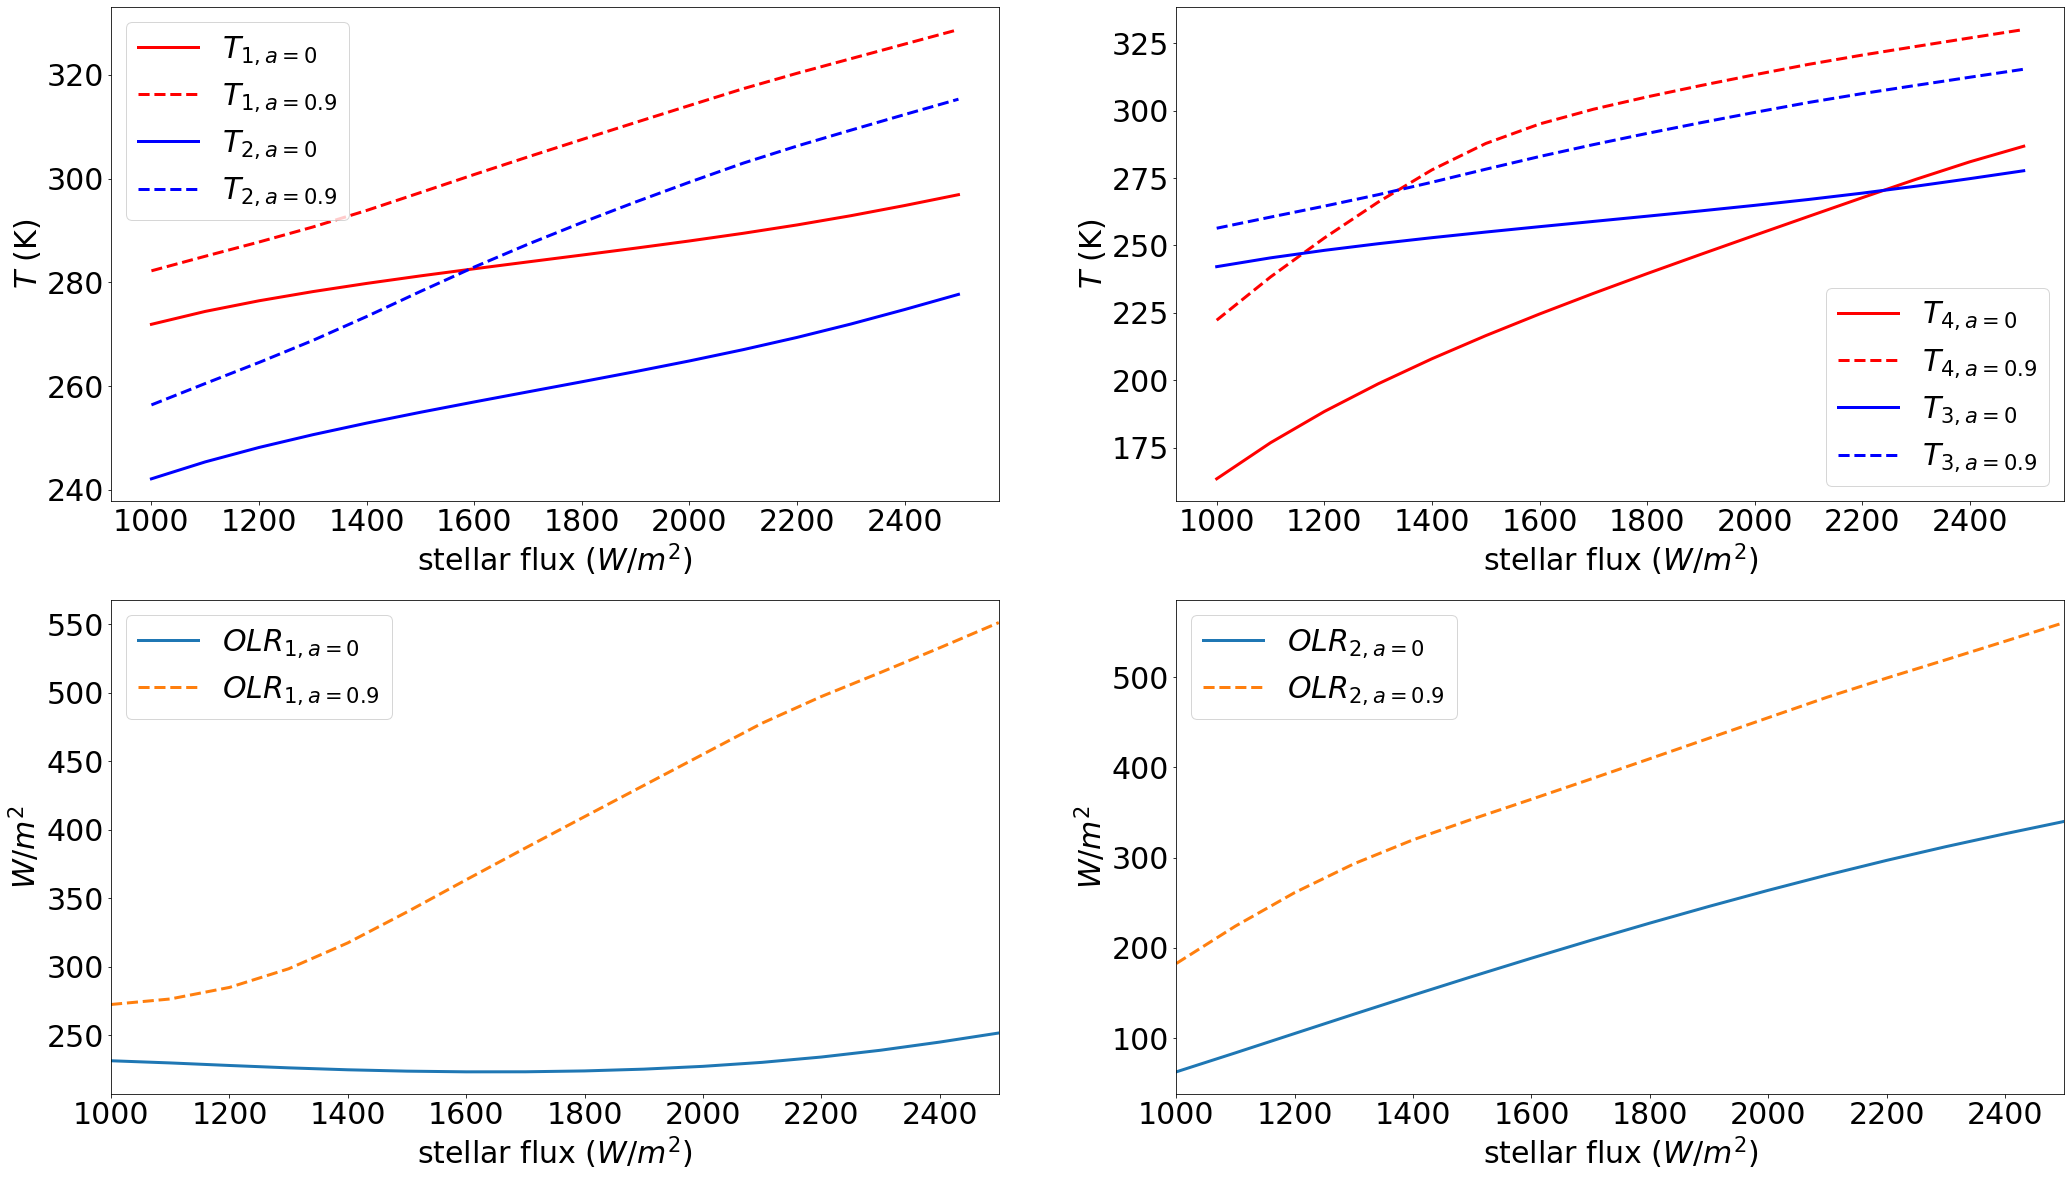

In [121]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, T1_arr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0}$')
    ax[0,0].plot(so, T1_brr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(so, T2_arr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0}$')
    ax[0,0].plot(so, T2_brr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(so, T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
    ax[0,1].plot(so, T4_brr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
    ax[0,1].plot(so, T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
    ax[0,1].plot(so, T3_brr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].legend()
    
    # Dayside energy budgets
    ax[1,0].plot(so, OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
    ax[1,0].plot(so, OLR1_brr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Nightside energy budgets
    ax[1,1].plot(so, OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
    ax[1,1].plot(so, OLR2_brr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

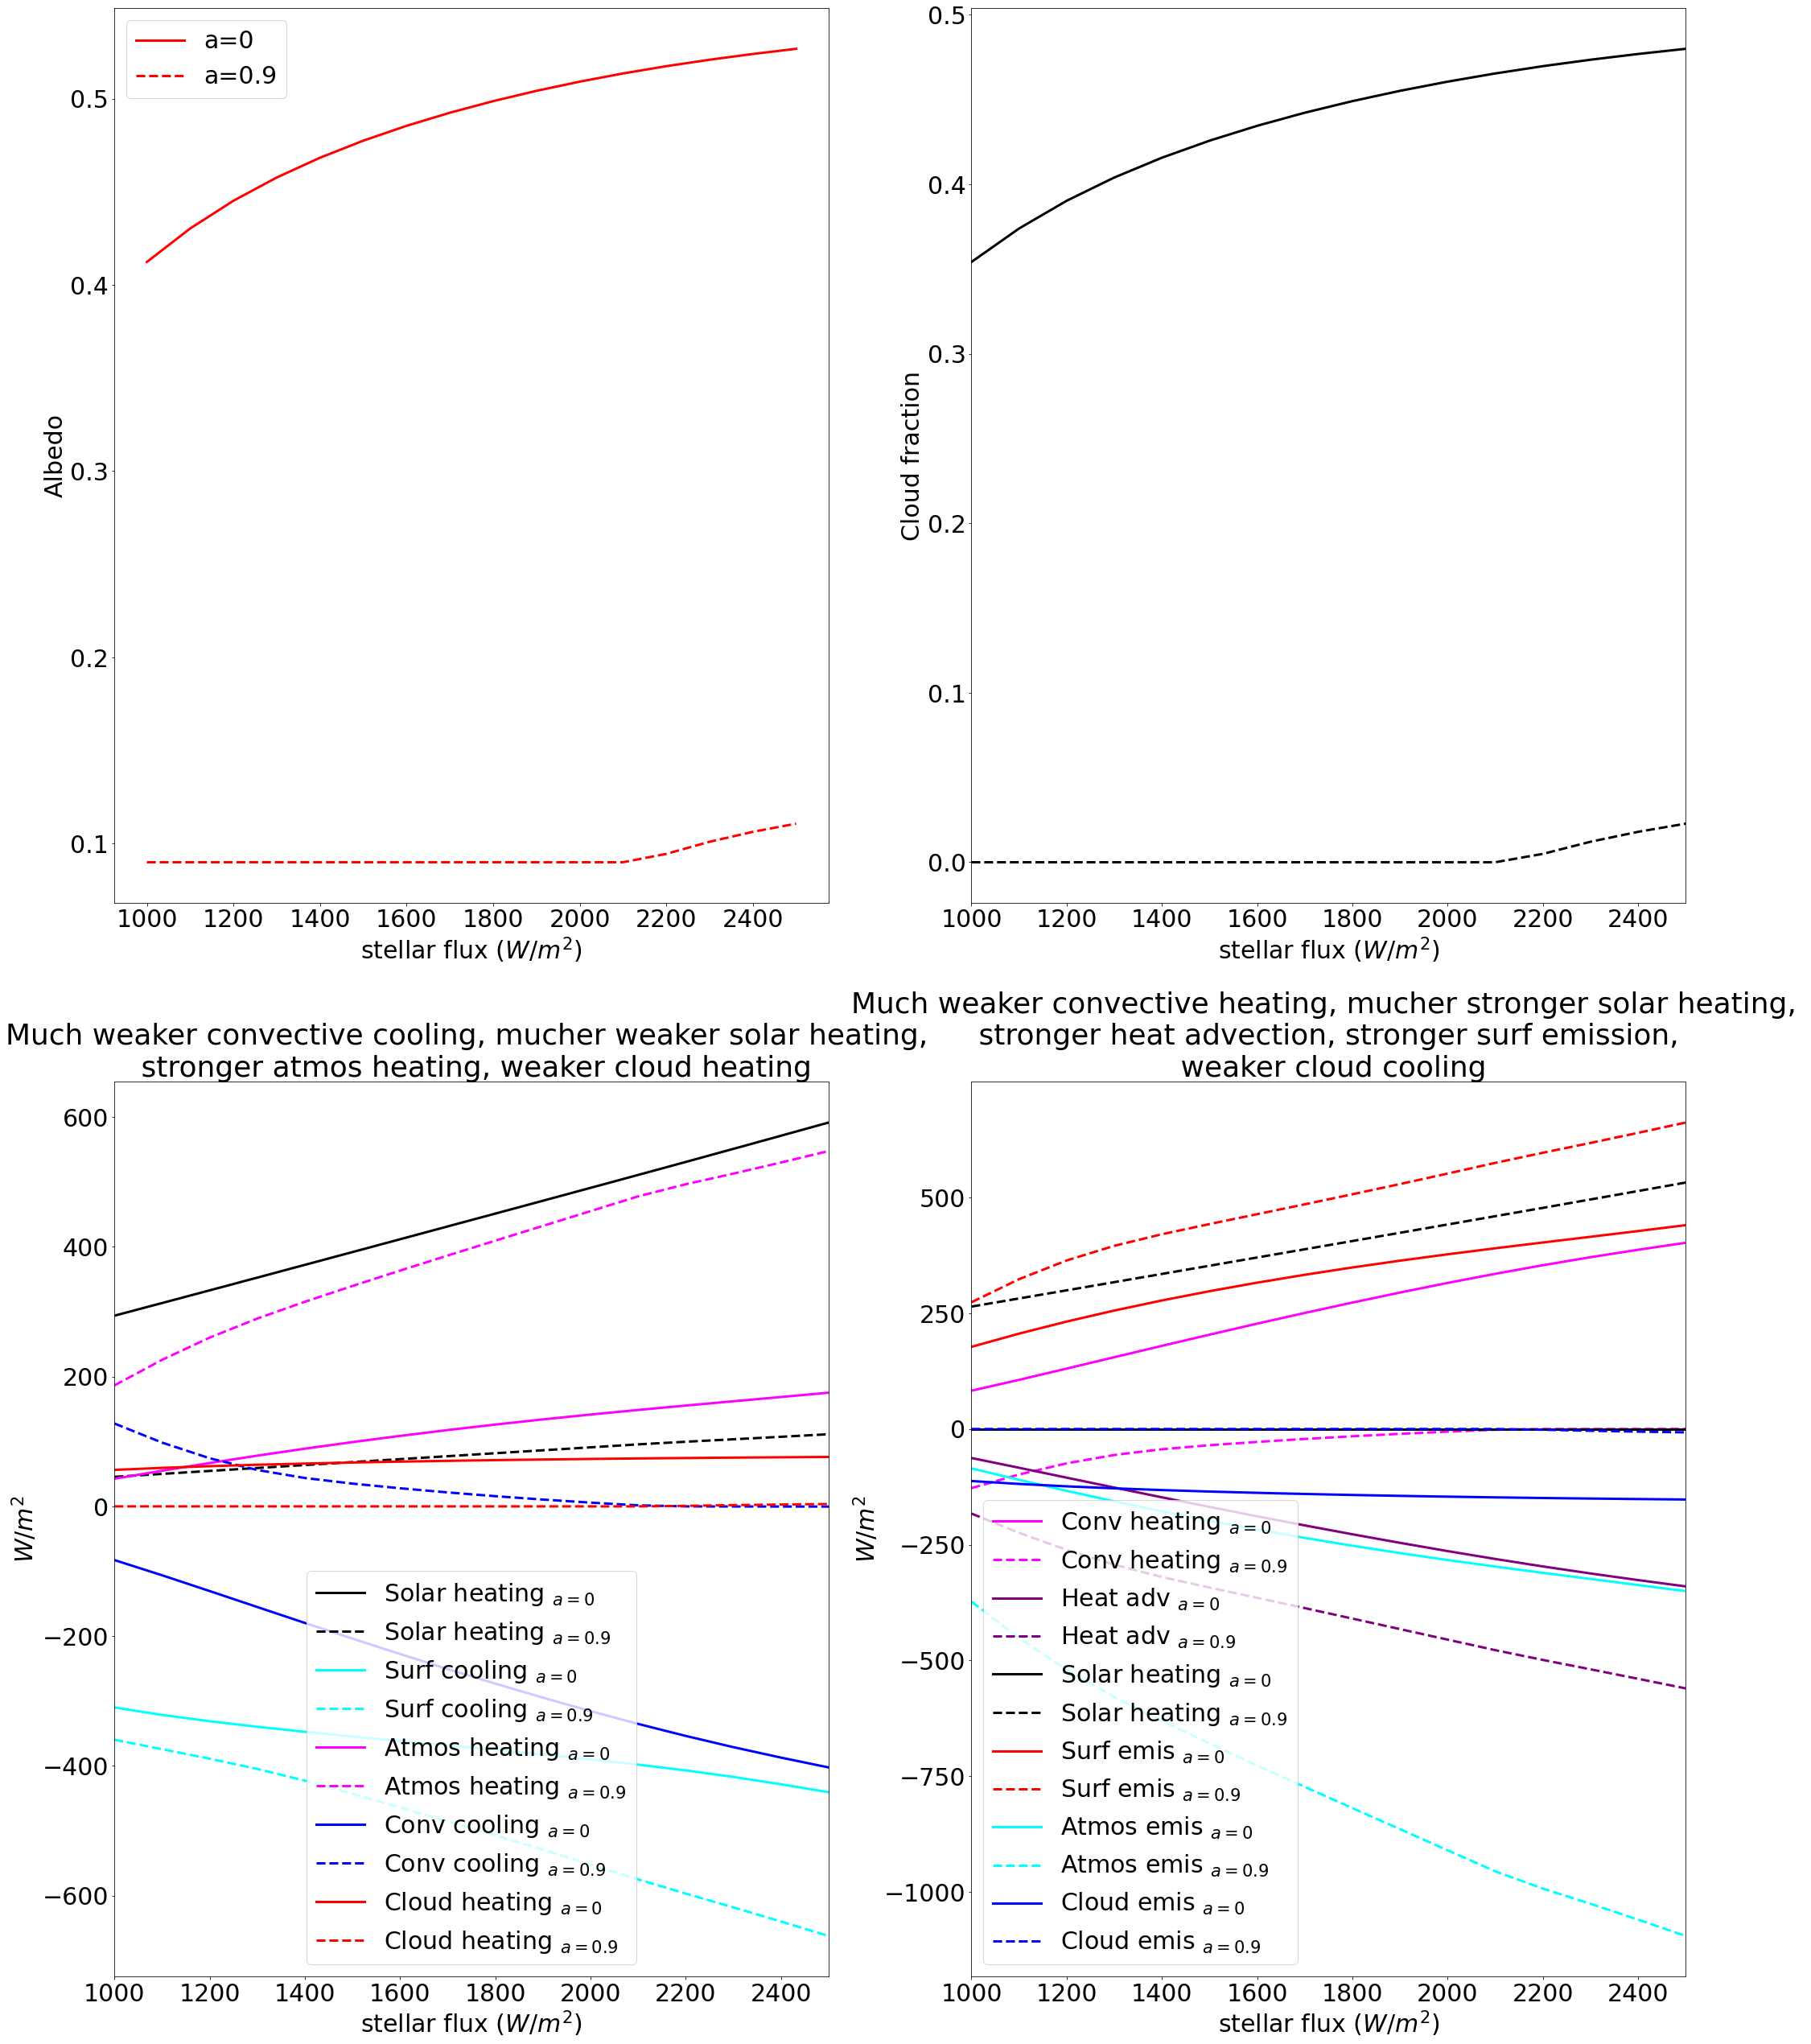

In [124]:
def plot_test(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    sigma = 5.67e-8
    Tc = 230
    a = 0.9
    
    fig, ax = plt.subplots(2, 2, figsize=(35,45)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(so, alpha_p_arr, '-', color = 'red',linewidth=3, label = "a=0")
    ax[0,0].plot(so, alpha_p_drr, '--', color = 'red', linewidth=3, label = "a=0.9")
    ax[0,0].set_ylabel("Albedo")
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].legend()
    
    # Dayside emmisivity
    ax[0,1].plot(so, fc_arr,'-', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0}$')
    ax[0,1].plot(so, fc_drr,'--', color = 'black',linewidth=3, label = r'$\epsilon_{2, a=0.9}$')
    ax[0,1].set_xlim([1000, 2500])
    ax[0,1].set_ylabel("Cloud fraction")
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    
    # Dayside energy budgets
    ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_drr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,0].plot(so, -sigma*T1_arr**4,'-', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0}$')
    ax[1,0].plot(so, -sigma*T1_drr**4,'--', color = 'cyan',linewidth=3, label = r'Surf cooling $_{a=0.9}$')
    ax[1,0].plot(so, (1-fc_arr)*Flux2_arr,'-', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0}$')
    ax[1,0].plot(so, (1-fc_drr)*Flux2_drr,'--', color = 'magenta',linewidth=3, label = r'Atmos heating $_{a=0.9}$')
    ax[1,0].plot(so, -Fc_arr,'-', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0}$')
    ax[1,0].plot(so, -Fc_drr,'--', color = 'blue',linewidth=3, label = r'Conv cooling $_{a=0.9}$')
    ax[1,0].plot(so, fc_arr*sigma*Tc**4,'-', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0}$')
    ax[1,0].plot(so, fc_drr*sigma*Tc**4,'--', color = 'red',linewidth=3, label = r'Cloud heating $_{a=0.9}$')  
    
#     ax[1,0].plot(so, so/2*(1-0)*(1-alpha_p_arr) + fc_arr*sigma*Tc**4 - sigma*T1_arr**4 + (1-fc_arr)*Flux2_arr - Fc_arr,'-', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0}$')
#     ax[1,0].plot(so, so/2*(1-a)*(1-alpha_p_brr) + fc_brr*sigma*Tc**4 - sigma*T1_brr**4 + (1-fc_brr)*Flux2_brr - Fc_brr,'--', color = 'black', \
#                  linewidth=3, label = r'Trend$_{a=0.5}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    ax[1,0].set_title("Much weaker convective cooling, mucher weaker solar heating, \n stronger atmos heating, weaker cloud heating")
    
    # Nightside energy budgets
    ax[1,1].plot(so, Fc_arr,'-', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0}$')
    ax[1,1].plot(so, Fc_drr,'--', color = 'magenta',linewidth=3, label = r'Conv heating $_{a=0.9}$')
    ax[1,1].plot(so, -Fa_arr,'-', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0}$')
    ax[1,1].plot(so, -Fa_drr,'--', color = 'purple',linewidth=3, label = r'Heat adv $_{a=0.9}$')
    ax[1,1].plot(so, so/2*(1-1)*(1-alpha_p_arr),'-', color = 'black',linewidth=3, label = r'Solar heating $_{a=0}$')
    ax[1,1].plot(so, so/2*a*(1-alpha_p_arr),'--', color = 'black',linewidth=3, label = r'Solar heating $_{a=0.9}$')
    ax[1,1].plot(so, ((1-fc_arr)*epsilon_2_arr+fc_arr)*sigma*T1_arr**4,'-', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0}$')
    ax[1,1].plot(so, ((1-fc_brr)*epsilon_2_brr+fc_brr)*sigma*T1_brr**4,'--', \
                 color = 'red',linewidth=3, label = r'Surf emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*(1-fc_arr)*epsilon_2_arr*sigma*T2_arr**4,'-', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0}$')
    ax[1,1].plot(so, -2*(1-fc_brr)*epsilon_2_brr*sigma*T2_brr**4,'--', color = 'cyan',linewidth=3, label = r'Atmos emis $_{a=0.9}$')
    ax[1,1].plot(so, -2*fc_arr*sigma*Tc**4,'-', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0}$')
    ax[1,1].plot(so, -2*fc_brr*sigma*Tc**4,'--', color = 'blue',linewidth=3, label = r'Cloud emis $_{a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    ax[1,1].set_title("Much weaker convective heating, mucher stronger solar heating, \n stronger heat advection, stronger surf emission, \n weaker cloud cooling")
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_test(so)

In [86]:
# Example debug mode
S = 1000       # W/m2
T1_init = 328  # K
T2_init = 314  # K
T3_init = 314  # K
T4_init = 279  # K
Fa_init = 378  # W/m2
Fc_init = 318  # W/m2

(T1, T2, T3, T4, Fa, Fc,  \
 fc_2, q1, q2, q3, alpha_p, \
 epsilon_2, epsilon_3, OLR_day, OLR_night, \
 Flux1, Flux2, Flux3 ,Flux4, FluxC, \
 info, ier, msg) = solar_abs_func(So=S, assumption='WTG', debug=True, 
                                  p_guess = (T1_init, T2_init, T3_init, T4_init, \
                                             Fa_init, Fc_init))
print("\n")
print("T1 = {} K".format(round(T1,2)))
print("T2 = {} K".format(round(T2,2)))
print("T3 = {} K".format(round(T3,2)))
print("T4 = {} K".format(round(T4,2)))
print("F_a = {} W/m2".format(round(Fa,2)))
print("F_c = {} W/m2".format(round(Fc,2)))
print("dayside cloud fraction = {}".format(round(fc_2,2)))
print("dayside surface specific humidity = {} kg/kg".format(round(q1,4)))
print("dayside atmos specific humidity = {} kg/kg".format(round(q2,4)))
print("nightside atmos specific humidity = {} kg/kg".format(round(q3,6)))
print("planetary albedo = {}".format(round(alpha_p,3)))
print("dayside emissivity = {}".format(round(epsilon_2,3)))
print("nightside emissivity = {}".format(round(epsilon_3,3)))
print("dayside OLR = {} W/m2".format(round(OLR_day,1)))
print("nightside OLR = {} W/m2".format(round(OLR_night,1)))
print("dayside surface cooling = {} W/m2".format(round(Flux1,1)))
print("dayside atmospheric cooling = {} W/m2".format(round(Flux2,1)))
print("dayside cloud radiative effect = {} W/m2".format(round(FluxC,1)))
print("nightside surface cooling = {} W/m2".format(round(Flux3,1)))
print("nightside atmospheric cooling = {} W/m2".format(round(Flux4,1)))

We have a solution:  (271.93242131284876, 242.15574550503877, 242.15574550503877, 163.63364678959007, 62.873677140347525, 81.98156189711551)


T1 = 271.93 K
T2 = 242.16 K
T3 = 242.16 K
T4 = 163.63 K
F_a = 62.87 W/m2
F_c = 81.98 W/m2
dayside cloud fraction = 0.35
dayside surface specific humidity = 0.0032 kg/kg
dayside atmos specific humidity = 0.0004 kg/kg
nightside atmos specific humidity = 0.000155 kg/kg
planetary albedo = 0.412
dayside emissivity = 0.339
nightside emissivity = 0.144
dayside OLR = 231.3 W/m2
nightside OLR = 62.9 W/m2
dayside surface cooling = 204.8 W/m2
dayside atmospheric cooling = 66.2 W/m2
dayside cloud radiative effect = -39.7 W/m2
nightside surface cooling = 28.1 W/m2
nightside atmospheric cooling = 166.9 W/m2


NameError: name 'Fd_hrr' is not defined

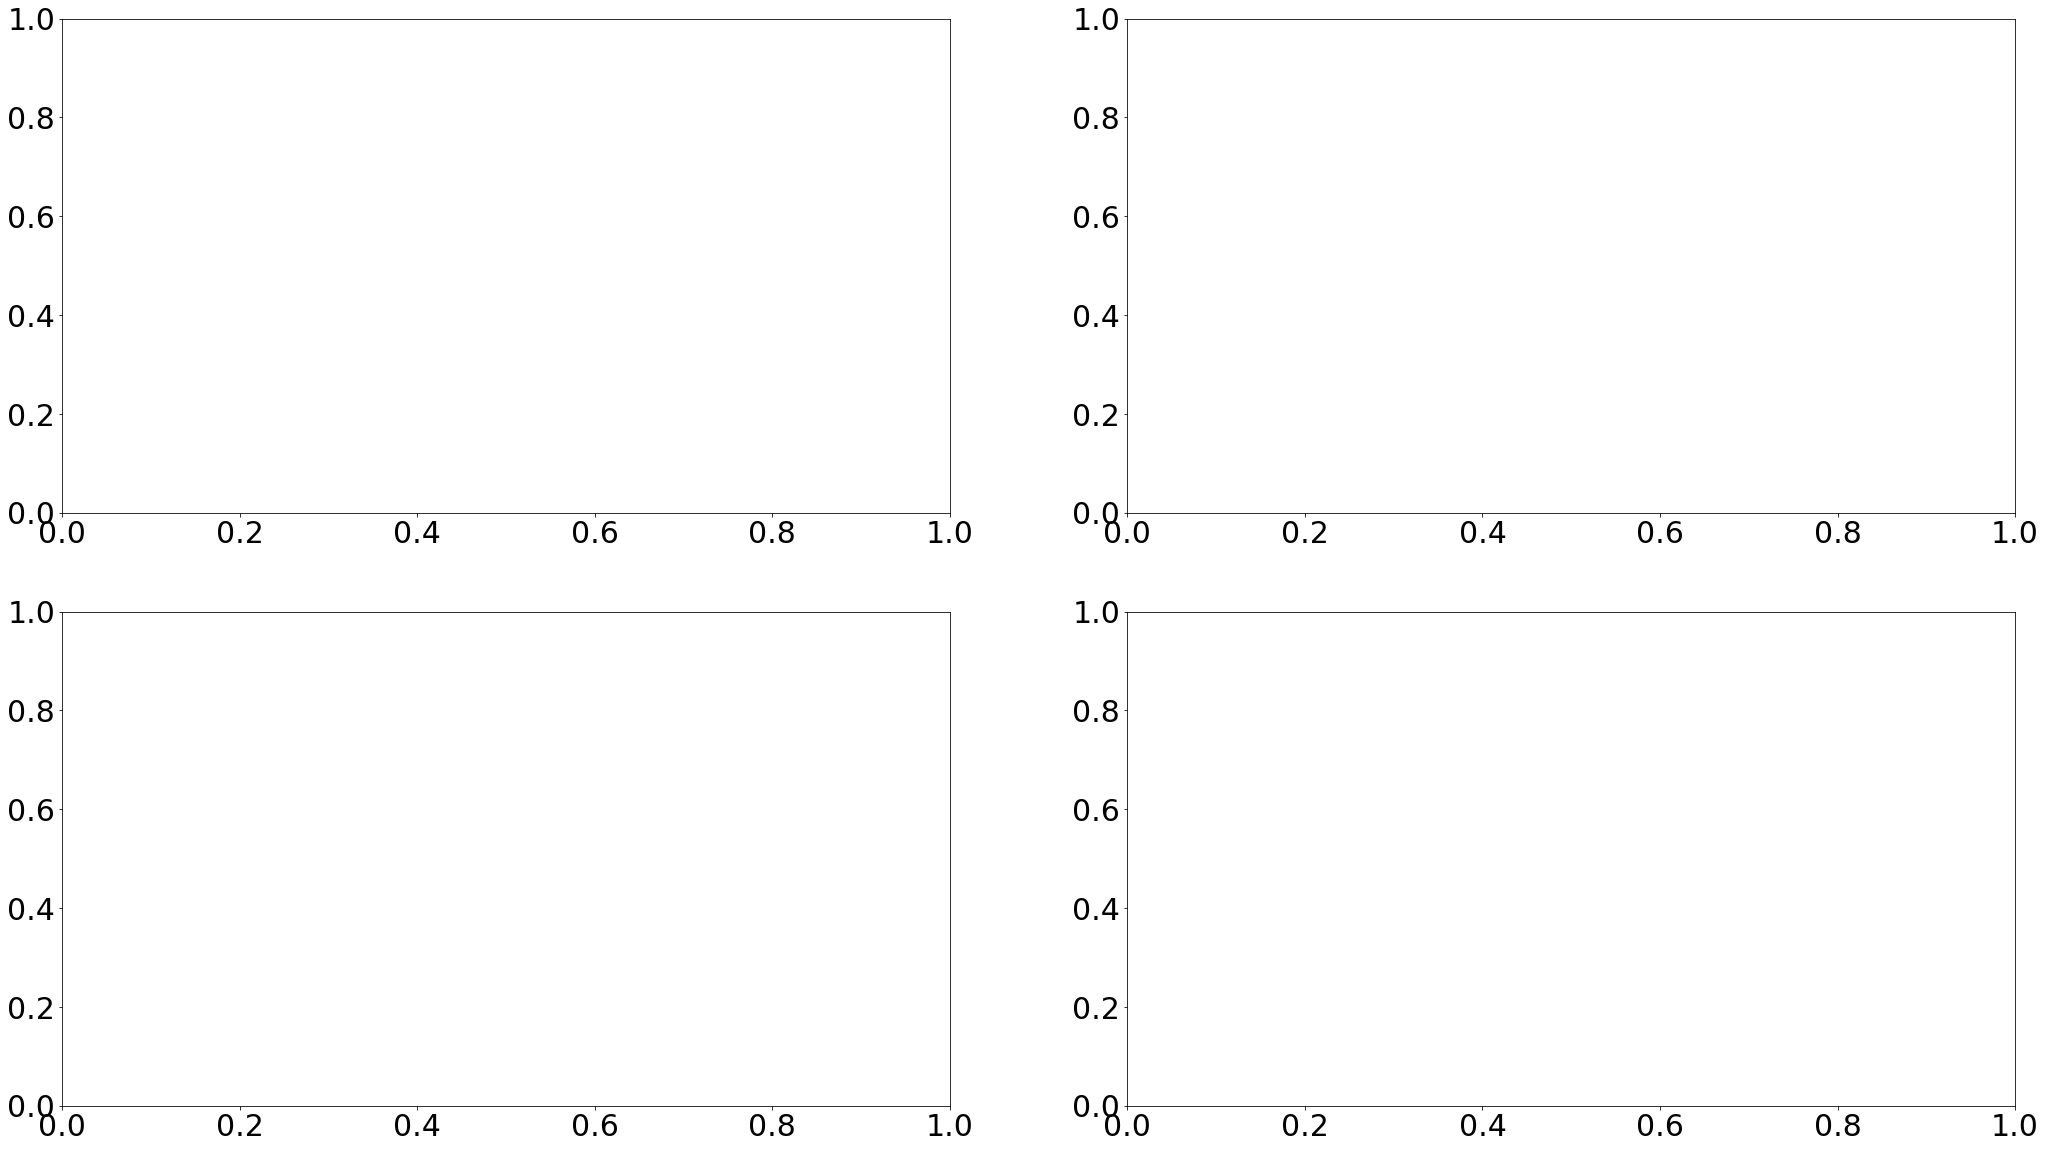

In [326]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
#     # Dayside temperature structure
#     ax[0,0].plot(so, T1_a, '-',linewidth=3, label = r'$T_{a}$')
#     ax[0,0].plot(so, T1_b, '-', linewidth=3, label = r'$T_{b}$')
#     ax[0,0].plot(so, T1_c, '-', linewidth=3, label = r'$T_{c}$')
#     ax[0,0].plot(so, T1_d, '-',linewidth=3, label = r'$T_{d}$')
#     ax[0,0].plot(so, T1_e, '-',linewidth=3, label = r'$T_{e}$')
#     ax[0,0].set_ylabel(r'$T$ (K)')
#     ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,0].legend()
    
#     # Nightside temperature structure
#     ax[0,1].plot(so, T2_a, '-',linewidth=3, label = r'$T_{a}$')
#     ax[0,1].plot(so, T2_b, '-', linewidth=3, label = r'$T_{b}$')
#     ax[0,1].plot(so, T2_c, '-', linewidth=3, label = r'$T_{c}$')
#     ax[0,1].plot(so, T2_d, '-',linewidth=3, label = r'$T_{d}$')
#     ax[0,1].plot(so, T2_e, '-',linewidth=3, label = r'$T_{e}$')
#     ax[0,1].set_ylabel(r'$T$ (K)')
#     ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[0,1].legend()
    
#     # Dayside energy budgets
#     ax[1,0].plot(so, T3_a, '-',linewidth=3, label = r'$T_{a}$')
#     ax[1,0].plot(so, T3_b, '-', linewidth=3, label = r'$T_{b}$')
#     ax[1,0].plot(so, T3_c, '-', linewidth=3, label = r'$T_{c}$')
#     ax[1,0].plot(so, T3_d, '-',linewidth=3, label = r'$T_{d}$')
#     ax[1,0].plot(so, T3_e, '-',linewidth=3, label = r'$T_{e}$')
#     ax[1,0].set_ylabel(r'$T$ (K)')
#     ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
#     ax[1,0].legend()
    
    # Nightside energy budgets
#     ax[1,1].plot(so, T4_a, '-',linewidth=3, label = r'$T_{a}$')
#     ax[1,1].plot(so, T4_b, '-', linewidth=3, label = r'$T_{b}$')
#     ax[1,1].plot(so, T4_c, '-', linewidth=3, label = r'$T_{c}$')
#     ax[1,1].plot(so, T4_d, '-',linewidth=3, label = r'$T_{d}$')
    ax[1,1].plot(so, Fd_hrr, '-',linewidth=3, label = r'$T_{e}$')
    ax[1,1].set_ylabel(r'$T$ (K)')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig

plot_abs(so)

In [122]:
so = np.linspace(800,2500,18)
print(so)
print(np.flip(so))

[ 800.  900. 1000. 1100. 1200. 1300. 1400. 1500. 1600. 1700. 1800. 1900.
 2000. 2100. 2200. 2300. 2400. 2500.]
[2500. 2400. 2300. 2200. 2100. 2000. 1900. 1800. 1700. 1600. 1500. 1400.
 1300. 1200. 1100. 1000.  900.  800.]


In [296]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_crr, T2_crr, T3_crr, T4_crr, Fa_crr, Fc_crr, fc_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_crr, q2_crr, q3_crr, alpha_p_crr, epsilon_2_crr, epsilon_3_crr, OLR1_crr, OLR2_crr, Flux1_crr, Flux2_crr, Flux3_crr, Flux4_crr, FluxC_crr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx], fc_crr[idx], \
        q1_crr[idx],q2_crr[idx],q3_crr[idx],alpha_p_crr[idx],epsilon_2_crr[idx],epsilon_3_crr[idx], \
        OLR1_crr[idx], OLR2_crr[idx], Flux1_crr[idx], Flux2_crr[idx], Flux3_crr[idx], Flux4_crr[idx], FluxC_crr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_crr[idx]= math.nan
        T2_crr[idx]= math.nan
        T3_crr[idx]= math.nan
        T4_crr[idx]= math.nan
    else:
        initial_guess = (T1_crr[idx], T2_crr[idx], T3_crr[idx], T4_crr[idx], Fa_crr[idx], Fc_crr[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (328.72195189552235, 315.29991098416053, 315.29991098416053, 330.0039662840711, 560.3746123552688, 0.3291889283610317)
1 2450.0
We have a solution:  (327.3224974253483, 313.82589496607216, 313.82589496607216, 328.4612093228802, 549.9689399242601, 0.29166000401157666)
2 2400.0
We have a solution:  (325.91944216188324, 312.338884287668, 312.338884287668, 326.904851694303, 539.6190553483178, 0.25150786050937163)
3 2350.0
We have a solution:  (324.513942078017, 310.8392042032729, 310.8392042032729, 325.3352338202154, 529.3296393327346, 0.20864714800962558)
4 2300.0
We have a solution:  (323.1072151034426, 309.32721871176693, 309.32721871176693, 323.7527366746098, 519.1054704296015, 0.1630263497224169)
5 2250.0
We have a solution:  (321.7005333206329, 307.8033286084488, 307.8033286084488, 322.1577797439686, 508.95139249822165, 0.11463611616437595)
6 2200.0
We have a solution:  (320.2952125527355, 306.26796808102176, 306.26796808102176, 320.55081746440004, 498.8

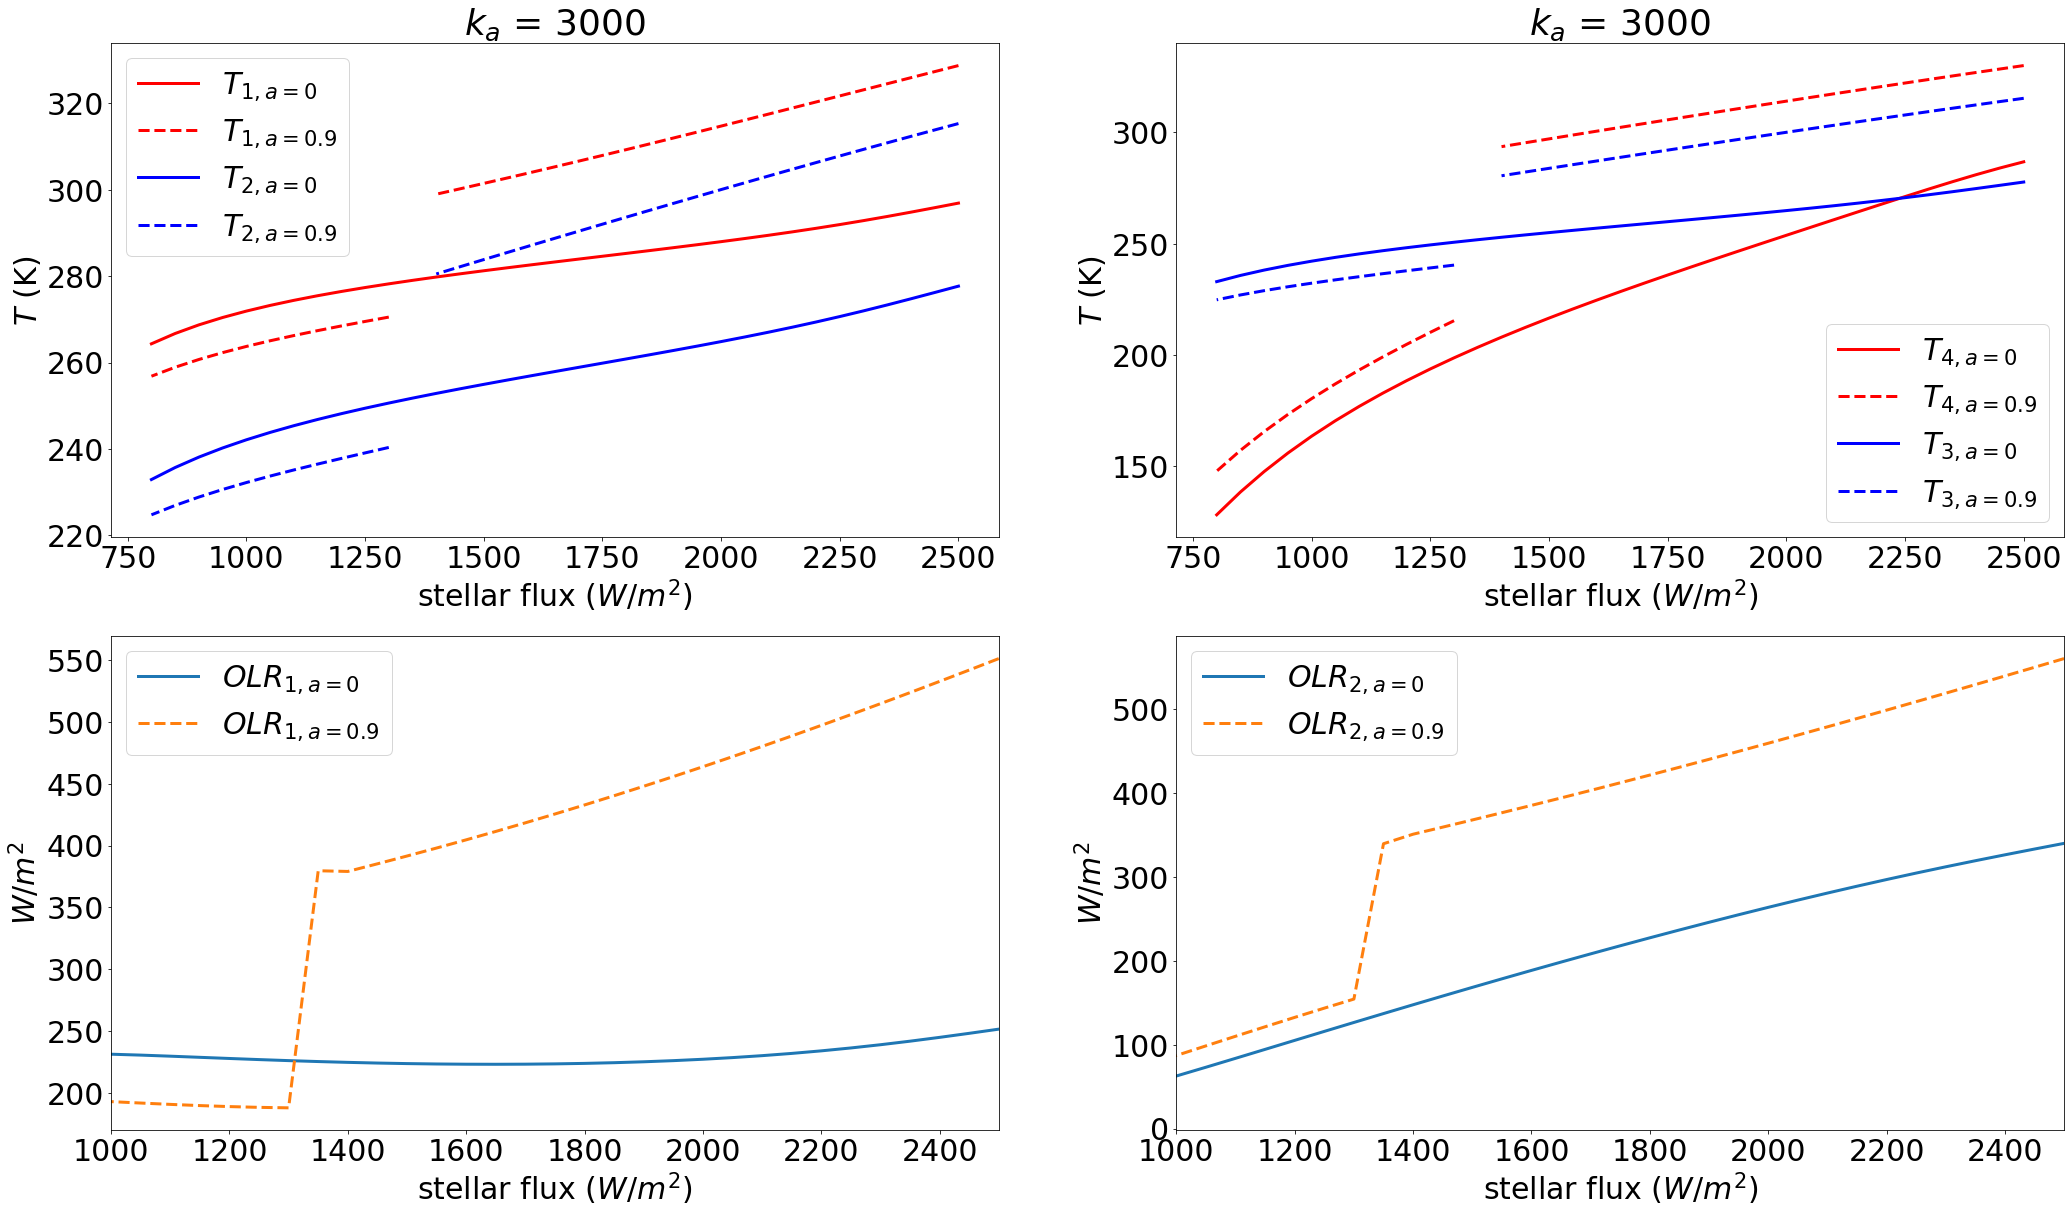

In [252]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(2, 2, figsize=(35,20)) 
    plt.rc('font', size = 30) 
    
    # Dayside temperature structure
    ax[0,0].plot(np.flip(so), T1_arr, '-', color = 'red',linewidth=3, label = r'$T_{1, a=0}$')
    ax[0,0].plot(so, T1_crr, '--', color = 'red', linewidth=3, label = r'$T_{1, a=0.9}$')
    ax[0,0].plot(np.flip(so), T2_arr, '-', color = 'blue', linewidth=3, label = r'$T_{2, a=0}$')
    ax[0,0].plot(so, T2_crr, '--', color = 'blue',linewidth=3, label = r'$T_{2, a=0.9}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'$k_a$ = 3000')
    ax[0,0].legend()
    
    # Nightside temperature structure
    ax[0,1].plot(np.flip(so), T4_arr, '-', color = 'red',linewidth=3, label = r'$T_{4, a=0}$')
    ax[0,1].plot(so, T4_crr, '--', color = 'red', linewidth=3, label = r'$T_{4, a=0.9}$')
    ax[0,1].plot(np.flip(so), T3_arr, '-', color = 'blue', linewidth=3, label = r'$T_{3, a=0}$')
    ax[0,1].plot(so, T3_crr, '--', color = 'blue',linewidth=3, label = r'$T_{3, a=0.9}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'$k_a$ = 3000')
    ax[0,1].legend()
    
    # Dayside energy budgets
    ax[1,0].plot(np.flip(so), OLR1_arr,'-',linewidth=3, label = r'$OLR_{1, a=0}$')
    ax[1,0].plot(so, OLR1_crr,'--',linewidth=3, label = r'$OLR_{1, a=0.9}$')
    ax[1,0].set_xlim([1000, 2500])
    ax[1,0].set_ylabel(r'$W/m^2$')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].legend()
    
    # Nightside energy budgets
    ax[1,1].plot(np.flip(so), OLR2_arr,'-',linewidth=3, label = r'$OLR_{2, a=0}$')
    ax[1,1].plot(so, OLR2_crr,'--',linewidth=3, label = r'$OLR_{2, a=0.9}$')
    ax[1,1].set_xlim([1000, 2500])
    ax[1,1].set_ylabel(r'$W/m^2$')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

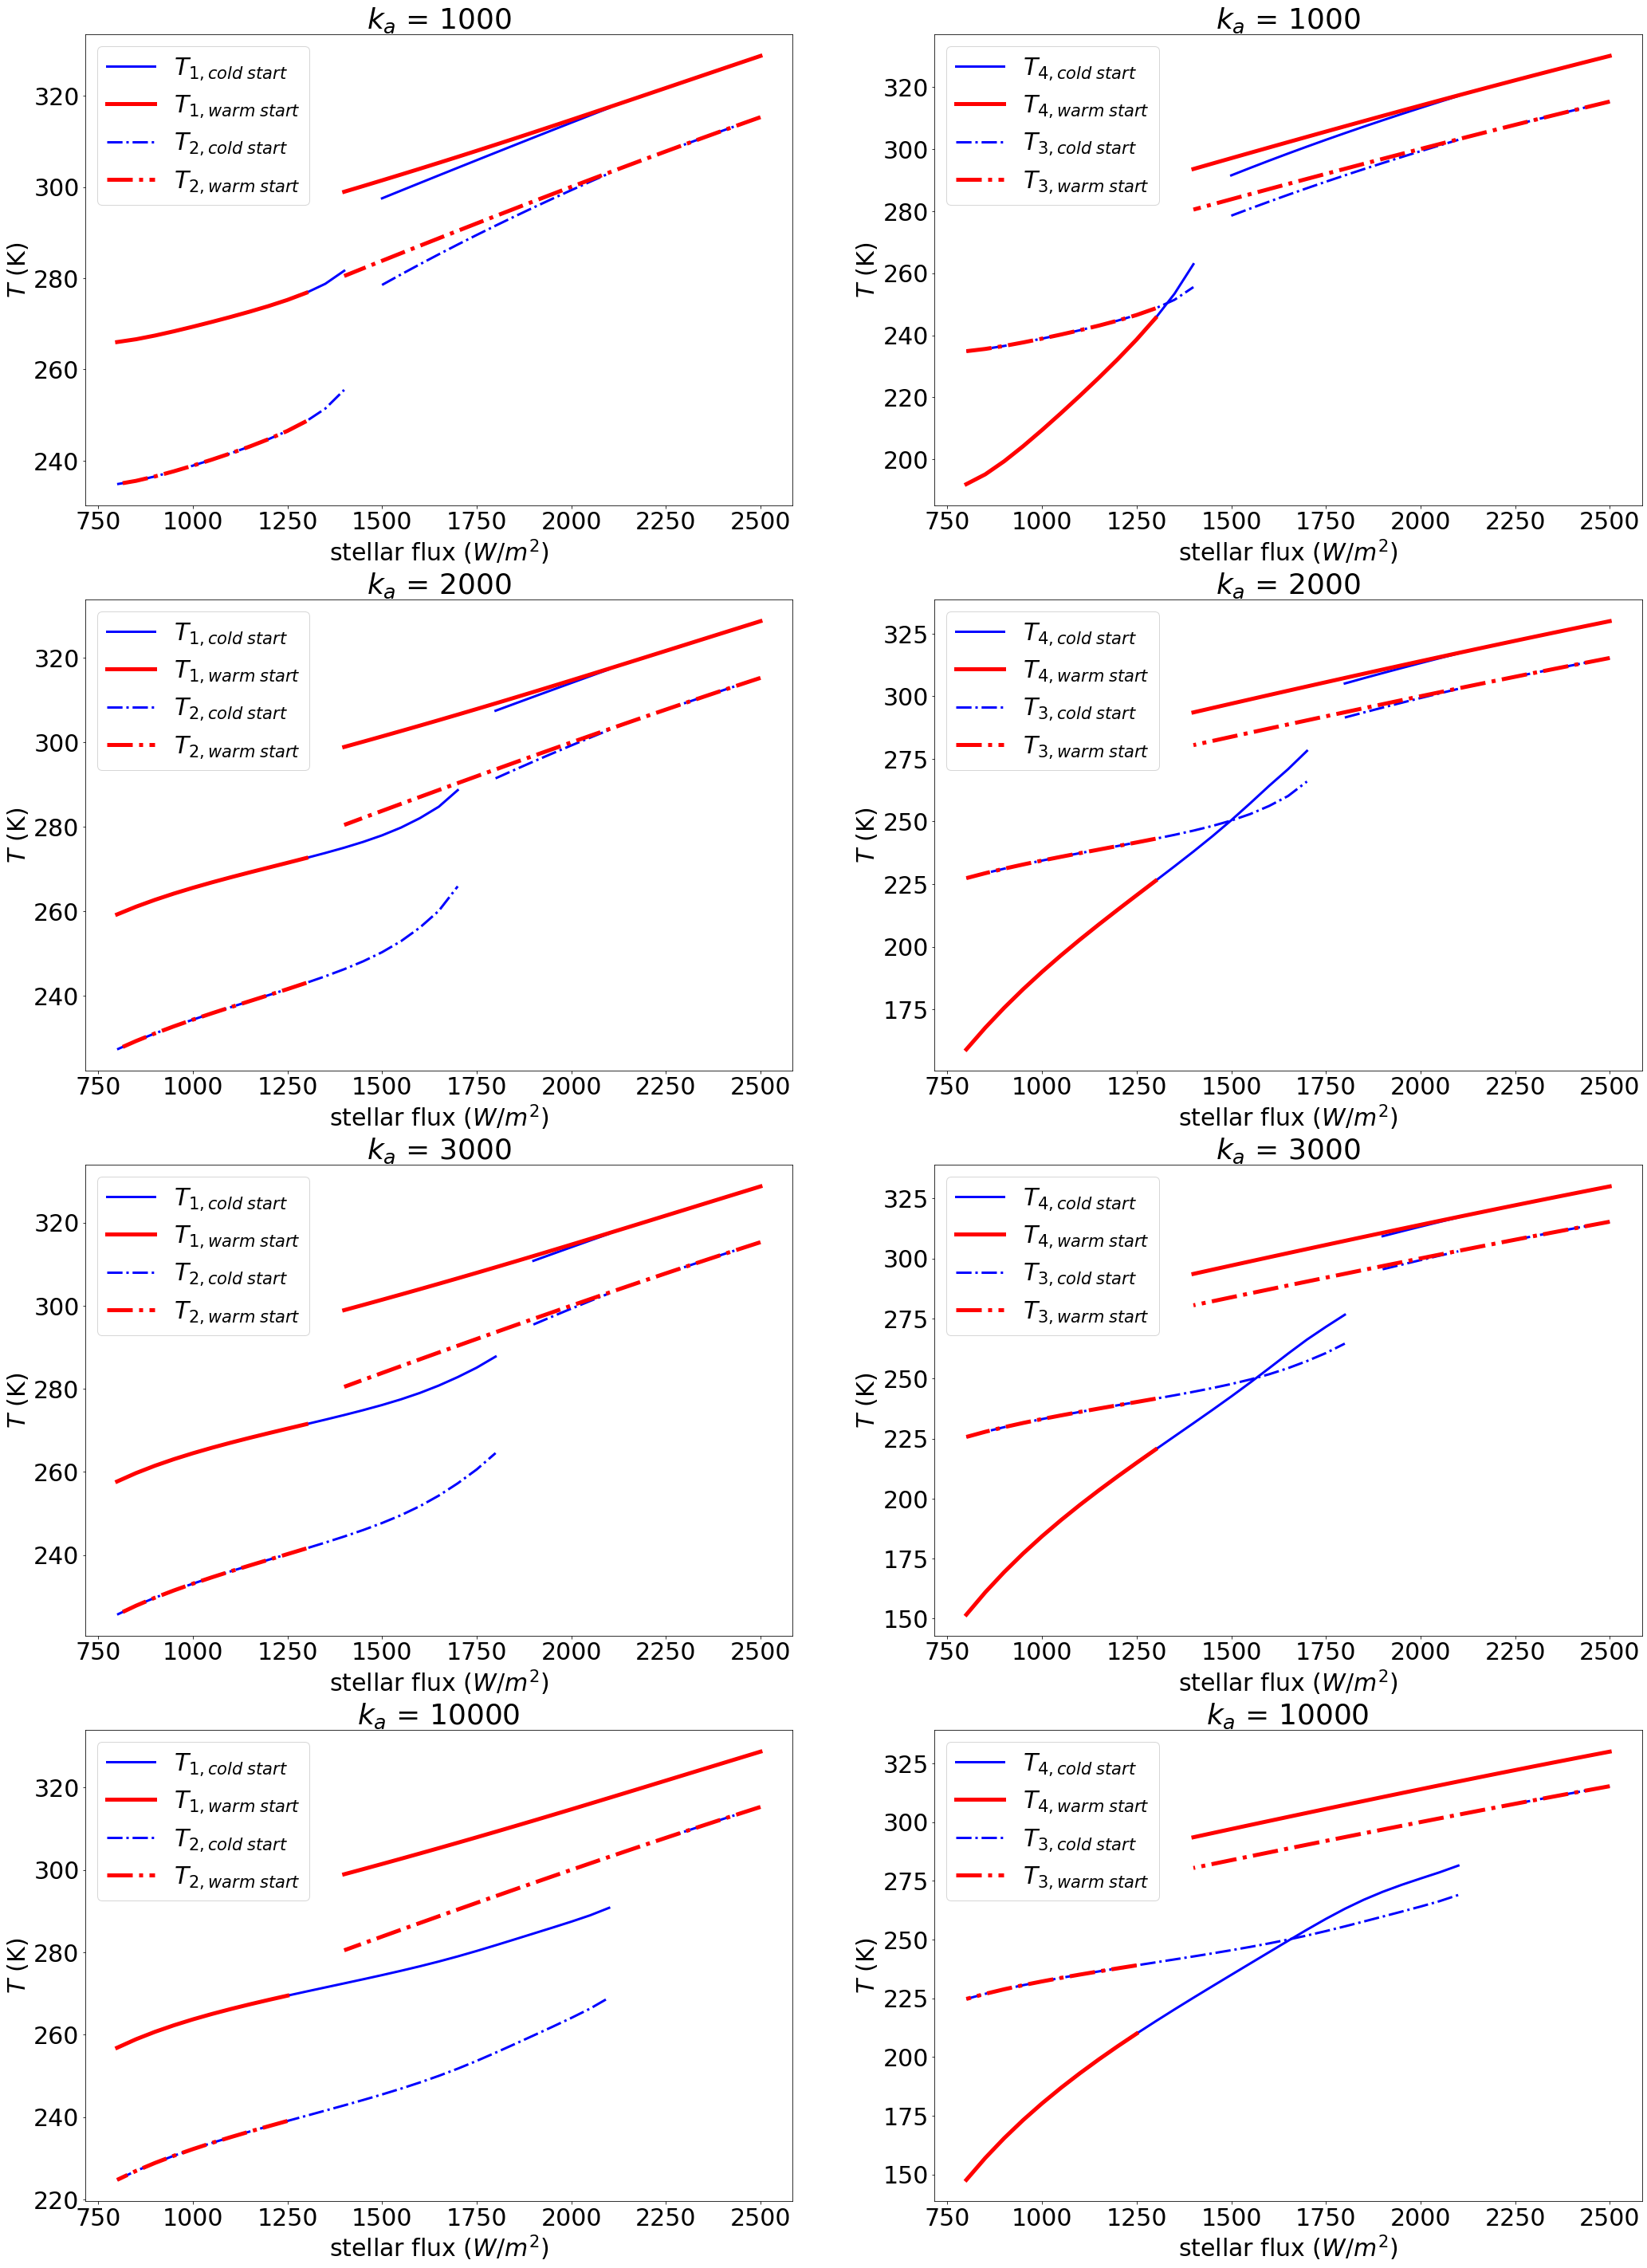

In [312]:
def plot_abs(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    
    fig, ax = plt.subplots(4, 2, figsize=(35,50)) 
    plt.rc('font', size = 30) 

    # Dayside energy budgets
    ax[0,0].plot(np.flip(so), T1_brr, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold\;start}$')
    ax[0,0].plot(so, T1_crr, '-', color = 'red', linewidth=5, label = r'$T_{1, warm\;start}$')
    ax[0,0].plot(np.flip(so), T2_brr, '-.', color = 'blue', linewidth=3, label = r'$T_{2, cold\;start}$')
    ax[0,0].plot(so, T2_crr, '-.', color = 'red',linewidth=5, label = r'$T_{2, warm\;start}$')
    ax[0,0].set_ylabel(r'$T$ (K)')
    ax[0,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,0].set_title(r'$k_a$ = 1000')
    ax[0,0].legend()
    
    # Nightside energy budgets
    ax[0,1].plot(np.flip(so), T4_brr, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold\;start}$')
    ax[0,1].plot(so, T4_crr, '-', color = 'red', linewidth=5, label = r'$T_{4, warm\;start}$')
    ax[0,1].plot(np.flip(so), T3_brr, '-.', color = 'blue', linewidth=3, label = r'$T_{3, cold\;start}$')
    ax[0,1].plot(so, T3_crr, '-.', color = 'red',linewidth=5, label = r'$T_{3, warm\;start}$')
    ax[0,1].set_ylabel(r'$T$ (K)')
    ax[0,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[0,1].set_title(r'$k_a$ = 1000')
    ax[0,1].legend()
    
    # Dayside temperature structure
    ax[1,0].plot(np.flip(so), T1_drr, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold\;start}$')
    ax[1,0].plot((so), T1_err, '-', color = 'red', linewidth=5, label = r'$T_{1, warm\;start}$')
    ax[1,0].plot(np.flip(so), T2_drr, '-.', color = 'blue', linewidth=3, label = r'$T_{2, cold\;start}$')
    ax[1,0].plot((so), T2_err, '-.', color = 'red',linewidth=5, label = r'$T_{2, warm\;start}$')
    ax[1,0].set_ylabel(r'$T$ (K)')
    ax[1,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,0].set_title(r'$k_a$ = 2000')
    ax[1,0].legend()
    
    # Nightside temperature structure
    ax[1,1].plot(np.flip(so), T4_drr, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold\;start}$')
    ax[1,1].plot((so), T4_err, '-', color = 'red', linewidth=5, label = r'$T_{4, warm\;start}$')
    ax[1,1].plot(np.flip(so), T3_drr, '-.', color = 'blue', linewidth=3, label = r'$T_{3, cold\;start}$')
    ax[1,1].plot((so), T3_err, '-.', color = 'red',linewidth=5, label = r'$T_{3, warm\;start}$')
    ax[1,1].set_ylabel(r'$T$ (K)')
    ax[1,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[1,1].set_title(r'$k_a$ = 2000')
    ax[1,1].legend()
    
    # Dayside temperature structure
    ax[2,0].plot(np.flip(so), T1_frr, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold\;start}$')
    ax[2,0].plot(so, T1_grr, '-', color = 'red', linewidth=5, label = r'$T_{1, warm\;start}$')
    ax[2,0].plot(np.flip(so), T2_frr, '-.', color = 'blue', linewidth=3, label = r'$T_{2, cold\;start}$')
    ax[2,0].plot(so, T2_grr, '-.', color = 'red',linewidth=5, label = r'$T_{2, warm\;start}$')
    ax[2,0].set_ylabel(r'$T$ (K)')
    ax[2,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,0].set_title(r'$k_a$ = 3000')
    ax[2,0].legend()
    
    # Nightside temperature structure
    ax[2,1].plot(np.flip(so), T4_frr, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold\;start}$')
    ax[2,1].plot(so, T4_grr, '-', color = 'red', linewidth=5, label = r'$T_{4, warm\;start}$')
    ax[2,1].plot(np.flip(so), T3_frr, '-.', color = 'blue', linewidth=3, label = r'$T_{3, cold\;start}$')
    ax[2,1].plot(so, T3_grr, '-.', color = 'red',linewidth=5, label = r'$T_{3, warm\;start}$')
    ax[2,1].set_ylabel(r'$T$ (K)')
    ax[2,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[2,1].set_title(r'$k_a$ = 3000')
    ax[2,1].legend()
    
    # Dayside temperature structure
    ax[3,0].plot(np.flip(so), T1_hrr, '-', color = 'blue',linewidth=3, label = r'$T_{1, cold\;start}$')
    ax[3,0].plot((so), T1_irr, '-', color = 'red', linewidth=5, label = r'$T_{1, warm\;start}$')
    ax[3,0].plot(np.flip(so), T2_hrr, '-.', color = 'blue', linewidth=3, label = r'$T_{2, cold\;start}$')
    ax[3,0].plot((so), T2_irr, '-.', color = 'red',linewidth=5, label = r'$T_{2, warm\;start}$')
    ax[3,0].set_ylabel(r'$T$ (K)')
    ax[3,0].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[3,0].set_title(r'$k_a$ = 10000')
    ax[3,0].legend()
    
    # Nightside temperature structure
    ax[3,1].plot(np.flip(so), T4_hrr, '-', color = 'blue',linewidth=3, label = r'$T_{4, cold\;start}$')
    ax[3,1].plot((so), T4_irr, '-', color = 'red', linewidth=5, label = r'$T_{4, warm\;start}$')
    ax[3,1].plot(np.flip(so), T3_hrr, '-.', color = 'blue', linewidth=3, label = r'$T_{3, cold\;start}$')
    ax[3,1].plot((so), T3_irr, '-.', color = 'red',linewidth=5, label = r'$T_{3, warm\;start}$')
    ax[3,1].set_ylabel(r'$T$ (K)')
    ax[3,1].set_xlabel(r'stellar flux ($W/m^2$)')
    ax[3,1].set_title(r'$k_a$ = 10000')
    ax[3,1].legend()
    
    plt.close()
        
    return fig
# plt.style.use('ggplot')
plot_abs(so)

In [297]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

# With temperature-varying absorption
def solar_abs_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))

        def epsilon(q):
            k2 = 5000
            if q < 0:
                q = 0
            epsilon = 1 - np.exp(-k2*q)
            return epsilon        
        epsilon_2 = epsilon(q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = epsilon(q3)
        
#         epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 2e3      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [298]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_drr, T2_drr, T3_drr, T4_drr, Fa_drr, Fc_drr, fc_drr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_drr, q2_drr, q3_drr, alpha_p_drr, epsilon_2_drr, epsilon_3_drr, OLR1_drr, OLR2_drr, Flux1_drr, Flux2_drr, Flux3_drr, Flux4_drr, FluxC_drr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_drr[idx], T2_drr[idx], T3_drr[idx], T4_drr[idx], Fa_drr[idx], Fc_drr[idx], fc_drr[idx], \
        q1_drr[idx],q2_drr[idx],q3_drr[idx],alpha_p_drr[idx],epsilon_2_drr[idx],epsilon_3_drr[idx], \
        OLR1_drr[idx], OLR2_drr[idx], Flux1_drr[idx], Flux2_drr[idx], Flux3_drr[idx], Flux4_drr[idx], FluxC_drr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_drr[idx], T2_drr[idx], T3_drr[idx], T4_drr[idx], Fa_drr[idx], Fc_drr[idx], fc_drr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_drr[idx], q2_drr[idx], q3_drr[idx], alpha_p_drr[idx], epsilon_2_drr[idx], epsilon_3_drr[idx], OLR1_drr[idx], OLR2_drr[idx], Flux1_drr[idx], Flux2_drr[idx], Flux3_drr[idx], Flux4_drr[idx], FluxC_drr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
#         T1_brr[idx]= math.nan
#         T2_brr[idx]= math.nan
#         T3_brr[idx]= math.nan
#         T4_brr[idx]= math.nan
    else:
        initial_guess = (T1_drr[idx], T2_drr[idx], T3_drr[idx], T4_drr[idx], Fa_drr[idx], Fc_drr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (259.31182726177036, 227.36490664691578, 227.36490664691578, 158.97261411500227, 55.348267246839406, 42.474078031966705)
1 850.0
We have a solution:  (261.1398036331559, 229.34311568141692, 229.34311568141692, 167.62602289119332, 67.15826149933963, 50.17875834979612)
2 900.0
We have a solution:  (262.7685281279875, 231.14719184382554, 231.14719184382554, 175.58914652706977, 79.2733650329, 58.118974582816755)
3 950.0
We have a solution:  (264.24571501981194, 232.81977801599191, 232.81977801599191, 182.9917832056736, 91.5685139187409, 66.11146128560016)
4 1000.0
We have a solution:  (265.6071632133138, 234.39381978937746, 234.39381978937746, 189.93859843728234, 103.94748952188604, 74.0069961431597)
5 1050.0
We have a solution:  (266.8809958083514, 235.896200373046, 235.896200373046, 196.51708468033527, 116.33762790378927, 81.67848124822791)
6 1100.0
We have a solution:  (268.09034406612443, 237.35009641081803, 237.35009641081803, 202.802610603183, 128.6843676

In [299]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_err, T2_err, T3_err, T4_err, Fa_err, Fc_err, fc_err = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_err, q2_err, q3_err, alpha_p_err, epsilon_2_err, epsilon_3_err, OLR1_err, OLR2_err, Flux1_err, Flux2_err, Flux3_err, Flux4_err, FluxC_err = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_err[idx], T2_err[idx], T3_err[idx], T4_err[idx], Fa_err[idx], Fc_err[idx], fc_err[idx], \
        q1_err[idx],q2_err[idx],q3_err[idx],alpha_p_err[idx],epsilon_2_err[idx],epsilon_3_err[idx], \
        OLR1_err[idx], OLR2_err[idx], Flux1_err[idx], Flux2_err[idx], Flux3_err[idx], Flux4_err[idx], FluxC_err[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_err[idx]= math.nan
        T2_err[idx]= math.nan
        T3_err[idx]= math.nan
        T4_err[idx]= math.nan
    else:
        initial_guess = (T1_err[idx], T2_err[idx], T3_err[idx], T4_err[idx], Fa_err[idx], Fc_err[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (328.72195189552235, 315.29991098416053, 315.29991098416053, 330.0039662840711, 560.3746123552688, 0.3291889283610317)
1 2450.0
We have a solution:  (327.3224974253483, 313.82589496607216, 313.82589496607216, 328.4612093228802, 549.9689399242601, 0.29166000401157666)
2 2400.0
We have a solution:  (325.91944216188324, 312.338884287668, 312.338884287668, 326.904851694303, 539.6190553483178, 0.25150786050937163)
3 2350.0
We have a solution:  (324.513942078017, 310.8392042032729, 310.8392042032729, 325.3352338202154, 529.3296393327346, 0.20864714800962558)
4 2300.0
We have a solution:  (323.1072151034426, 309.32721871176693, 309.32721871176693, 323.7527366746098, 519.1054704296015, 0.1630263497224169)
5 2250.0
We have a solution:  (321.7005333206329, 307.8033286084488, 307.8033286084488, 322.1577797439686, 508.95139249822165, 0.11463611616437595)
6 2200.0
We have a solution:  (320.2952125527355, 306.26796808102176, 306.26796808102176, 320.55081746440004, 498.8

In [309]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

# With temperature-varying absorption
def solar_abs_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 3000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))

        def epsilon(q):
            k2 = 5000
            if q < 0:
                q = 0
            epsilon = 1 - np.exp(-k2*q)
            return epsilon        
        epsilon_2 = epsilon(q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = epsilon(q3)
        
#         epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 3e3      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [310]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_frr, T2_frr, T3_frr, T4_frr, Fa_frr, Fc_frr, fc_frr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_frr, q2_frr, q3_frr, alpha_p_frr, epsilon_2_frr, epsilon_3_frr, OLR1_frr, OLR2_frr, Flux1_frr, Flux2_frr, Flux3_frr, Flux4_frr, FluxC_frr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (280,250,250,220,200,100)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_frr[idx], T2_frr[idx], T3_frr[idx], T4_frr[idx], Fa_frr[idx], Fc_frr[idx], fc_frr[idx], \
        q1_frr[idx],q2_frr[idx],q3_frr[idx],alpha_p_frr[idx],epsilon_2_frr[idx],epsilon_3_frr[idx], \
        OLR1_frr[idx], OLR2_frr[idx], Flux1_frr[idx], Flux2_frr[idx], Flux3_frr[idx], Flux4_frr[idx], FluxC_frr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_frr[idx], T2_frr[idx], T3_frr[idx], T4_frr[idx], Fa_frr[idx], Fc_frr[idx], fc_frr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_frr[idx], q2_frr[idx], q3_frr[idx], alpha_p_frr[idx], epsilon_2_frr[idx], epsilon_3_frr[idx], OLR1_frr[idx], OLR2_frr[idx], Flux1_frr[idx], Flux2_frr[idx], Flux3_frr[idx], Flux4_frr[idx], FluxC_frr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
#         T1_brr[idx]= math.nan
#         T2_brr[idx]= math.nan
#         T3_brr[idx]= math.nan
#         T4_brr[idx]= math.nan
    else:
        initial_guess = (T1_frr[idx], T2_frr[idx], T3_frr[idx], T4_frr[idx], Fa_frr[idx], Fc_frr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (257.7145674334761, 225.673559254133, 225.673559254133, 151.67751059560143, 46.49491386793973, 61.95880742410584)
1 850.0
We have a solution:  (259.7418468724364, 227.82604376934745, 227.82604376934745, 160.97972635014884, 57.960734847391805, 70.9697756811155)
2 900.0
We have a solution:  (261.5083530573909, 229.74780503531855, 229.74780503531855, 169.4080331321775, 69.76658234375961, 80.39598343180394)
3 950.0
We have a solution:  (263.0804007232611, 231.49735977623553, 231.49735977623553, 177.1387368063515, 81.76668213847022, 90.00548103038291)
4 1000.0
We have a solution:  (264.5052260854693, 233.1173550680869, 233.1173550680869, 184.3076922163199, 93.85333486528955, 99.62395139810386)
5 1050.0
We have a solution:  (265.8179348700688, 234.64039546486032, 234.64039546486032, 191.02268229865757, 105.94717466459817, 109.11409348526047)
6 1100.0
We have a solution:  (267.0457031003103, 236.09261320855768, 236.09261320855768, 197.37156939175281, 117.989364648

In [311]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_grr, T2_grr, T3_grr, T4_grr, Fa_grr, Fc_grr, fc_grr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_grr, q2_grr, q3_grr, alpha_p_grr, epsilon_2_grr, epsilon_3_grr, OLR1_grr, OLR2_grr, Flux1_grr, Flux2_grr, Flux3_grr, Flux4_grr, FluxC_grr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_grr[idx], T2_grr[idx], T3_grr[idx], T4_grr[idx], Fa_grr[idx], Fc_grr[idx], fc_grr[idx], \
        q1_grr[idx],q2_grr[idx],q3_grr[idx],alpha_p_grr[idx],epsilon_2_grr[idx],epsilon_3_grr[idx], \
        OLR1_grr[idx], OLR2_grr[idx], Flux1_grr[idx], Flux2_grr[idx], Flux3_grr[idx], Flux4_grr[idx], FluxC_grr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_grr[idx]= math.nan
        T2_grr[idx]= math.nan
        T3_grr[idx]= math.nan
        T4_grr[idx]= math.nan
    else:
        initial_guess = (T1_grr[idx], T2_grr[idx], T3_grr[idx], T4_grr[idx], Fa_grr[idx], Fc_grr[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (328.72195189552235, 315.29991098416053, 315.29991098416053, 330.0039662840711, 560.3746123552688, 0.3291889283610317)
1 2450.0
We have a solution:  (327.3224974253483, 313.82589496607216, 313.82589496607216, 328.4612093228802, 549.9689399242601, 0.29166000401157666)
2 2400.0
We have a solution:  (325.91944216188324, 312.338884287668, 312.338884287668, 326.904851694303, 539.6190553483178, 0.25150786050937163)
3 2350.0
We have a solution:  (324.513942078017, 310.8392042032729, 310.8392042032729, 325.3352338202154, 529.3296393327346, 0.20864714800962558)
4 2300.0
We have a solution:  (323.1072151034426, 309.32721871176693, 309.32721871176693, 323.7527366746098, 519.1054704296015, 0.1630263497224169)
5 2250.0
We have a solution:  (321.7005333206329, 307.8033286084488, 307.8033286084488, 322.1577797439686, 508.95139249822165, 0.11463611616437595)
6 2200.0
We have a solution:  (320.2952125527355, 306.26796808102176, 306.26796808102176, 320.55081746440004, 498.8

In [303]:
# Orinigal version: by Wencheng Shao, Maya Fields, Ziwei Wang, and Da Yang in Rossbypalooza 2022
# Updated version: by Bowen Fan (bowen27@uchicago.edu)

from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


''' This python notebook includes Virtual temperature correction for the MSE equations (Eq7 and Eq6). It also uses the fc minimum
function instead of defining a specific value. Heat capacity correction has been added.'''

# With temperature-varying absorption
def solar_abs_func(So=1360, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20),debug=False):
    # Input parameters
    # So: solar constant in W/m2
    # Fo: oceanic heat transport in W/m2
    # mm_dry: molar mass of dry air
    # assumption: weak temperature gradient (WTG) or weak buoyancy gradient (WBG)
    # p_guess: the starting estimate of the solutions
    
    g = 13.7                # gravity in m/s2
    Pc = 6e4                # depth of convection in Pa, called as Pa in the paper 
    Po = 1.01e5             # surface pressure in Pa *(needs to be fixed for steam atmos)
    R_star = 8.3145         # universal gas constant
    k3 = 0.08               # relates the strength of convection to the cloud fraction
    sigma = 5.67e-8 # Stefan-Boltzmann Constant in W/m2/K4 
    Tc = 230                    # cloud emission temperature (FAT)
    
    def equations(p):  # Define the equations to solve
        T1, T2, T3, T4, Fa, Fc = p 

        ### Constants
        #print('solving or calculating ...')
        es0 = 611.2         # reference pressure for CC relation
        M = 0.018           # molar mass of water vapor
        To = 273.15         # reference temperature for CC relation
        mass_ratio = M/mm_dry    # mass ratio between vapor and dry air
      
        H = ((R_star/mm_dry)*T2)/g  # scale height of dry atmosphere
        
        
        Z_a = np.log(Po/Pc)*H       # convection height* (needs to be fixed for steam atmos)
        Cpd = 1005.7                # heat capacity of dry air in J/kg/K
        Cpv = 1996                  # heat capacity of vapor in J/kg/K 
        L = 2.501e6                 # latent heat of vaporization in J/kg
        
        RH1 = 0.9 # Dayside surface relative humidity
        RH2 = 0.8 # Dayside atmosphere relative humidity
        RH3 = 0.3 # Nightside atmosphere relative humidity
        
        # water vapor calculations for dayside surface
        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1)) # saturation vapor pressure at dayside surface
        # *needs to be fixed: mass mixing ratio of water assuming saturation (vapor/dry)
        ws_1 = mass_ratio*es_1/(Po - es_1)               
        w_1 = RH1 * ws_1                                 # vapor pressure at dayside surface
        q1 = w_1/(1+w_1)                                 # specific humidity at dayside surface
        q1_s = ws_1/(1+ws_1)                             # saturation specific humidity at dayside surf (vapor/total)

        # water vapor calcaulations for dayside atmosphere
        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        ws_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        w_2 = RH2 * ws_2
        q2 = w_2/(1+w_2)
        q2_s = ws_2/(1+ws_2)
        
        # water vapor calculations for nightside atmosphere
        es_3 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T3))
        ws_3 = mass_ratio*es_3/(Pc - es_3) #saturated mixing ratio
        w_3 = RH3 * ws_3
        q3 = w_3/(1+w_3)
        
        Cp1 = Cpd*(1 - q1) + Cpv * q1  # specific heat of mixed air at dayside surf
        Cp2 = Cpd*(1 - q2) + Cpv * q2  # specific heat of mixed air at dayside atmos
        
        k1 = 0.2  # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity (need to be checked)
    
        Fd = k1*Fa   # a fraction of atmos heat transport in the boundary layer
        
        if Fc + 1.0 <= 0:
#             print("Error in cloud fraction calculation, Fc+1 = {}, fc set as 0".format(Fc+1.0))
            fc = 0
        else:
            fc = k3*np.log(Fc+1.0)     # expression of cloud fraction versus convection
            if fc >= 1:  # unrealistic case when we get cloud fraction larger than 1 (Fc larger than 2.8e6 W/m2)
                print("Cloud fraction too high, corrected as 1")
                fc = 1
        
        alpha_p = 0.09 + fc - 0.09*fc # planetary albedo versus dayside cloud fraction
        
        def Tv(T, mass_ratio, w):               # virtual temperature
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        # approximation for clear-sky water vapor emission
#         def tau(T, Tft):
#             tau = 0.56 + 0.07*np.exp(5413*((1/Tft)-(1/T)))
#             return tau           
#         epsilon_2 = 1/(1+tau(T2, 273))
#         epsilon_3 = 1/(1+tau(T3, 273))

        def epsilon(q):
            k2 = 5000
            if q < 0:
                q = 0
            epsilon = 1 - np.exp(-k2*q)
            return epsilon        
        epsilon_2 = epsilon(q2) # clear sky water vapor emissivity (need to be fixed)
        epsilon_3 = epsilon(q3)
        
#         epsilon_2 = 1 - np.exp(-k2*q2) # clear sky water vapor emissivity (need to be fixed)
#         epsilon_3 = 1 - np.exp(-k2*q3)
        
        def a(T):         # temperature varying absorption
#             a = 0.5
            Tref0 = 280   # Temperature of full absorption limit 
            a0 = 0.9      # Max water vapor absorption to sunlight
            ka = 1e4      # exponetional factor (like CC relation)
            if T <= Tref0:
                a = a0*np.exp(-ka*(1/T - 1/Tref0))
            else:
                a = a0
            return a
        
        # Corrected dayside surface energy equation
        Eq2 = (1/2)*So*(1-alpha_p)*(1-a(T2)) - Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        # Corrected dayside atmos energy equation
        Eq3 = (1/2)*So*(1-alpha_p)*a(T2) + Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        Eq6_WTG = T2 - T3      # weak temperature gradient assumption

        Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))   # weak buoyancy assumption

        Eq7_WTG = Cp1*T1 + L*q1 - (Cp2*T2+L*q2_s + g*Z_a)  # convective neutrality by temperature
        # convective neutrality by buoyancy (calculate q1,q2 based on T or Tv?)
        Eq7_WBG = Cp1*Tv(T1,mass_ratio,(q1/(1-q1))) + L*q1 - (Cp2*Tv(T2,mass_ratio,(q2/(1-q2)))+L*q2_s + g*Z_a)
        
        # dayside outgoing longwave radiation
        OLR_day = fc*sigma*Tc**4 +(1 - epsilon_2)*(1-fc)*sigma*T1**4 + (1-fc)*epsilon_2*sigma*T2**4
        # nightside outgoing longwave radiation
        OLR_night = (1 - epsilon_3)*sigma*T4**4 + epsilon_3*sigma*T3**4
        
        Flux1 = (1-epsilon_2)*sigma*T1**4
        Flux2 = epsilon_2*sigma*T2**4
        Flux3 = epsilon_3*sigma*T3**4
        Flux4 = (1-epsilon_3)*sigma*T3**4
        
        if assumption == 'WTG':                         
            Eq6 = Eq6_WTG
            Eq7 = Eq7_WTG                       
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
            Eq7 = Eq7_WBG
            
        if index==0:
            return (Eq2, Eq3, Eq4, Eq5, Eq6, Eq7)
        if index==1:
            return(fc, q1, q2, q3, alpha_p, epsilon_2, epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4)
    
    # Solve the equations using fsolve function
    index=0
    (T1, T2, T3, T4, Fa, Fc), info, ier, msg = fsolve(equations, p_guess, full_output=True)
    if ier==1:  # a solution is found
        print ('We have a solution: ', (T1, T2, T3, T4, Fa, Fc))
    
    # Extract the additional terms
    index=1
    #print('Solved.')
    fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3, OLR_day, OLR_night, Flux1, Flux2, Flux3, Flux4 = equations((T1, T2, T3, T4, Fa, Fc))
    FluxC = - (fc * (Flux1 + Flux2) - fc*sigma*Tc**4)
    
    # Ourput everything
    if debug==False: # Clean mode, only output prescribed variables
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC)
    else:            # Debug mode, output the messages from fsolve function
        return (T1, T2, T3, T4, Fa, Fc, fc, q1,q2,q3,alpha_p,epsilon_2,epsilon_3,OLR_day,OLR_night,Flux1,Flux2,Flux3,Flux4,FluxC,info,ier,msg)

In [304]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,17*2+1) # vary solar forcing from 1000 to 2500 W/m2
nele = len(so)

# generate the empty output space
T1_hrr, T2_hrr, T3_hrr, T4_hrr, Fa_hrr, Fc_hrr, fc_hrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_hrr, q2_hrr, q3_hrr, alpha_p_hrr, epsilon_2_hrr, epsilon_3_hrr, OLR1_hrr, OLR2_hrr, Flux1_hrr, Flux2_hrr, Flux3_hrr, Flux4_hrr, FluxC_hrr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (317.3231175858463, 302.97333300141696, 302.97333300141696, 317.10250973743655, 477.75002024925897, -1.596843162805312)

for idx, s in enumerate(so):
    print(idx, s)
    T1_hrr[idx], T2_hrr[idx], T3_hrr[idx], T4_hrr[idx], Fa_hrr[idx], Fc_hrr[idx], fc_hrr[idx], \
        q1_hrr[idx],q2_hrr[idx],q3_hrr[idx],alpha_p_hrr[idx],epsilon_2_hrr[idx],epsilon_3_hrr[idx], \
        OLR1_hrr[idx], OLR2_hrr[idx], Flux1_hrr[idx], Flux2_hrr[idx], Flux3_hrr[idx], Flux4_hrr[idx], FluxC_hrr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    
    if ier != 1:
        print("No solution")
#       initial_guess = (T1_brr[idx-1], T2_brr[idx-1], T3_brr[idx-1], T4_brr[idx-1], Fa_brr[idx-1], Fc_brr[idx-1])
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_hrr[idx], T2_hrr[idx], T3_hrr[idx], T4_hrr[idx], Fa_hrr[idx], Fc_hrr[idx], fc_hrr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
        q1_hrr[idx], q2_hrr[idx], q3_hrr[idx], alpha_p_hrr[idx], epsilon_2_hrr[idx], epsilon_3_hrr[idx], OLR1_hrr[idx], OLR2_hrr[idx], Flux1_hrr[idx], Flux2_hrr[idx], Flux3_hrr[idx], Flux4_hrr[idx], FluxC_hrr[idx] = math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan, math.nan
#         T1_brr[idx]= math.nan
#         T2_brr[idx]= math.nan
#         T3_brr[idx]= math.nan
#         T4_brr[idx]= math.nan
    else:
        initial_guess = (T1_hrr[idx], T2_hrr[idx], T3_hrr[idx], T4_hrr[idx], Fa_hrr[idx], Fc_hrr[idx])
        
#     initial_guess = (328, 314, 314, 300, 378, 318)
#     initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
    #print('end of loop ',initial_guess)

0 800.0
We have a solution:  (256.82628944173683, 224.7468927852311, 224.7468927852311, 147.7320940044827, 42.12120614074067, 75.12910940679625)
1 850.0
We have a solution:  (258.89780022291984, 226.92328572283893, 226.92328572283893, 157.05723130849762, 52.926520126554195, 86.17357621444243)
2 900.0
We have a solution:  (260.693371423206, 228.8555930709278, 228.8555930709278, 165.4838076587334, 64.10213207227747, 97.83312819623728)
3 950.0
We have a solution:  (262.28102223301545, 230.60291243544222, 230.60291243544222, 173.18230542455356, 75.48747196867585, 109.8738942070498)
4 1000.0
We have a solution:  (263.7094499241521, 232.20843467983914, 232.20843467983914, 180.28643761059044, 86.96363094325719, 122.12591966129861)
5 1050.0
We have a solution:  (265.0146556811883, 233.70485191854274, 233.70485191854274, 186.90265802699707, 98.44263071462898, 134.4631391743137)
6 1100.0
We have a solution:  (266.2240775391686, 235.11776482398142, 235.11776482398142, 193.11699653934159, 109.8587

In [305]:
# Calculate the solutions for WBG cases (the IEHZ is about 2000 W/m2)

sigma = 5.67e-8 # Stefan Boltzmann Constant in W/m2/K4  
so = np.linspace(800,2500,35) # vary solar forcing from 1000 to 2500 W/m2
so = np.flip(so)
nele = len(so)

# generate the empty output space
T1_irr, T2_irr, T3_irr, T4_irr, Fa_irr, Fc_irr, fc_irr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_irr, q2_irr, q3_irr, alpha_p_irr, epsilon_2_irr, epsilon_3_irr, OLR1_irr, OLR2_irr, Flux1_irr, Flux2_irr, Flux3_irr, Flux4_irr, FluxC_irr = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele),  np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

# the starting estimate of the solutions
initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
# initial_guess = (250,200,200,250,200,20)

for idx, s in enumerate(so):
    print(idx, s)
    T1_irr[idx], T2_irr[idx], T3_irr[idx], T4_irr[idx], Fa_irr[idx], Fc_irr[idx], fc_irr[idx], \
        q1_irr[idx],q2_irr[idx],q3_irr[idx],alpha_p_irr[idx],epsilon_2_irr[idx],epsilon_3_irr[idx], \
        OLR1_irr[idx], OLR2_irr[idx], Flux1_irr[idx], Flux2_irr[idx], Flux3_irr[idx], Flux4_irr[idx], FluxC_irr[idx], info,ier,msg = solar_abs_func(So = s, assumption  = 'WTG', p_guess=initial_guess, debug=True)
    if ier != 1:
        print("No solution")
        initial_guess = (328.1699893958025, 314.0326450833533, 314.0326450833533, 279.67551346862643, 378.90927762308166, 318.1347994089153)
        T1_irr[idx]= math.nan
        T2_irr[idx]= math.nan
        T3_irr[idx]= math.nan
        T4_irr[idx]= math.nan
    else:
        initial_guess = (T1_irr[idx], T2_irr[idx], T3_irr[idx], T4_irr[idx], Fa_irr[idx], Fc_irr[idx])
    #print('end of loop ',initial_guess)

0 2500.0
We have a solution:  (328.72195189552235, 315.29991098416053, 315.29991098416053, 330.0039662840711, 560.3746123552688, 0.3291889283610317)
1 2450.0
We have a solution:  (327.3224974253483, 313.82589496607216, 313.82589496607216, 328.4612093228802, 549.9689399242601, 0.29166000401157666)
2 2400.0
We have a solution:  (325.91944216188324, 312.338884287668, 312.338884287668, 326.904851694303, 539.6190553483178, 0.25150786050937163)
3 2350.0
We have a solution:  (324.513942078017, 310.8392042032729, 310.8392042032729, 325.3352338202154, 529.3296393327346, 0.20864714800962558)
4 2300.0
We have a solution:  (323.1072151034426, 309.32721871176693, 309.32721871176693, 323.7527366746098, 519.1054704296015, 0.1630263497224169)
5 2250.0
We have a solution:  (321.7005333206329, 307.8033286084488, 307.8033286084488, 322.1577797439686, 508.95139249822165, 0.11463611616437595)
6 2200.0
We have a solution:  (320.2952125527355, 306.26796808102176, 306.26796808102176, 320.55081746440004, 498.8

In [316]:
so = np.flip(so)